In [1]:
! nvidia-smi

Thu Apr 13 11:28:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:17:00.0 Off |                  Off |
| 41%   37C    P8    24W / 140W |      2MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A4000    Off  | 00000000:73:00.0 Off |                  Off |
| 41%   

In [2]:
############ Imports ############
import os
import zipfile
import numpy as np
import torch
import os
import cv2
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
from pylab import *
import nibabel as nib
from scipy import ndimage
import matplotlib.pyplot as plt
from os import path
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
import scipy.misc
import numpy.random as rng
from PIL import Image, ImageDraw, ImageFont
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import math
import glob
import re

In [3]:
import numpy as np # linear algebra
import pandas as pd # reading and processing of tables
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.misc

In [4]:
# check GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
!pip install pytictoc
from pytictoc import TicToc
t = TicToc()

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [6]:
mainVol = np.load('/home/norouzi1/Thesis_FinalResults/Covid/normalizeddata.npy')

In [7]:
mainVol.shape

(1009, 128, 128, 64)

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data):
        self.data = torch.from_numpy(data).float()

        
    def __getitem__(self, index):
        x = self.data[index]
        #x = process_scan(x)
        
        return x
    
    def __len__(self):
        return len(self.data)

trainData = MyDataset(mainVol)
train_loader = DataLoader(trainData,batch_size=10)  

In [9]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, input, size=131072):
        return input.view(input.size(0), 64, 16, 16, 8)

In [10]:
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True,
                 bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv3d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)

        self.bn = nn.BatchNorm3d(out_planes, eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        # print('conv block output',x.shape)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Autoencoders(nn.Module):
    def __init__(self):
        super(Autoencoders, self).__init__()

        self.relu = nn.ReLU(True)

        ##encoder layers
        self.conv_block_1 = BasicConv(1, 16, 3, stride=1, padding=1, bn=True, relu=True)
        self.conv_block_2 = BasicConv(16, 32, 3, stride=1, padding=1, bn=True, relu=True)
        self.conv_block_3 = BasicConv(32, 64, 3, stride=1, padding=1, bn=True, relu=True)
        self.max_pool = nn.MaxPool3d(2)
        self.flatten = Flatten()
        self.enclinear = nn.Linear(131072, 1024)
        ##decoder layers
        self.dec_convtrans_1 = nn.ConvTranspose3d(64, 32, 2, stride=2)
        self.dec_convtrans_2 = nn.ConvTranspose3d(32, 16, 2, stride=2)
        self.dec_convtrans_3 = nn.ConvTranspose3d(16, 1, 2, stride=2)
        self.deconv_batch_norm_1 = nn.BatchNorm3d(32)
        self.deconv_batch_norm_2 = nn.BatchNorm3d(16)
        self.unflatten = UnFlatten()
        self.declinear = nn.Linear(1024, 131072)

    def forward(self, x):
        # Encoder
        code1 = self.conv_block_1(x)
        # print("code1:", code1.shape)
        code1 = self.max_pool(code1)
        # print("code1:", code1.shape)
        code2 = self.conv_block_2(code1)
        # print("code2:", code2.shape)
        code2 = self.max_pool(code2)
        # print("code2:", code2.shape)
        code3 = self.conv_block_3(code2)
        # print("code3:", code3.shape)
        code3 = self.max_pool(code3)
        #print("code3:", code3.shape)
        code3 = self.flatten(code3)
        # print("code3:", code3.shape)
        code3 = self.enclinear(code3)
        # print("code3:", code3.shape)

        # Decoder
        out1 = self.declinear(code3)
        out1 = self.unflatten(out1)
        out1 = self.dec_convtrans_1(out1)
        # print("out1:", out1.shape)
        out1 = self.deconv_batch_norm_1(out1)
        # print("out1:", out1.shape)
        out2 = self.dec_convtrans_2(out1)
        # print("out2:", out2.shape)
        out2 = self.deconv_batch_norm_2(out2)
        # print("out2:", out2.shape)
        out3 = self.dec_convtrans_3(out2)
        # print("out3:", out3.shape)

        return code3, out3

In [11]:
model = Autoencoders()
model = model.to(device)
print(model)

Autoencoders(
  (relu): ReLU(inplace=True)
  (conv_block_1): BasicConv(
    (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (bn): BatchNorm3d(16, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv_block_2): BasicConv(
    (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (bn): BatchNorm3d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv_block_3): BasicConv(
    (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (bn): BatchNorm3d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (max_pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (enclinear): Linear(in_features=131072, out_features=1024, bias=True)
  (dec_convtrans_1): ConvTranspose3d(64, 32, ker

In [12]:
model = torch.load('/home/norouzi1/Thesis_FinalResults/Covid/SavedModels/Autoencoder.pth')
model.eval()

Autoencoders(
  (relu): ReLU(inplace=True)
  (conv_block_1): BasicConv(
    (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (bn): BatchNorm3d(16, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv_block_2): BasicConv(
    (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (bn): BatchNorm3d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv_block_3): BasicConv(
    (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (bn): BatchNorm3d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (max_pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (enclinear): Linear(in_features=131072, out_features=1024, bias=True)
  (dec_convtrans_1): ConvTranspose3d(64, 32, ker

In [13]:
enc_output = np.loadtxt('/home/norouzi1/Thesis_FinalResults/Covid/SavedModels/enc10.txt')
enc_output = enc_output.astype(int)

In [14]:
labels = np.loadtxt('/home/norouzi1/Thesis_FinalResults/Covid/SavedModels/labels.txt')
labels = labels.astype(int)

In [15]:
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.from_numpy(data).float()
        self.labels = labels.long()
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        
        return x, y
    
    def __len__(self):
        return len(self.data)

labels = torch.from_numpy(labels)
trainData = MyDataset(mainVol, labels)
train_loader = DataLoader(trainData,batch_size=10)  

In [16]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class ClassificationModel(nn.Module):   
    def __init__(self):
        super(ClassificationModel, self).__init__()

        self.features = nn.Sequential(
            # Defining a 3D convolution layer
            nn.Conv3d(1,64,3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool3d((2,2,2)),
            # Defining another 3D convolution layer
            nn.Conv3d(64,32,3, stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool3d((2,2,2)),
            # Defining another 3D convolution layer
            nn.Conv3d(32,16,3, stride=1, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool3d((2,2,2))
        )

        self.classifier = nn.Sequential(
            Flatten(),
            nn.Linear(32768, 256),
            nn.ReLU(inplace=True),
            #nn.Dropout3d(p=0.5),
            nn.Linear(256, 3)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [17]:
model = ClassificationModel()
model = model.to(device)
print(model)

ClassificationModel(
  (features): Sequential(
    (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv3d(64, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (5): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (9): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(

In [18]:
model = torch.load('/home/norouzi1/Thesis_FinalResults/Covid/SavedModels/Classifier.pth')

In [19]:
class GradCAMModel(nn.Module):
    def __init__(self):
        super(GradCAMModel, self).__init__()
        
        # get the classification network
        self.gradcam = model
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.gradcam.features[:11]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool3d((2,2,2))
        
        # get the classifier of the model
        self.classifier = self.gradcam.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

In [20]:
model2 = GradCAMModel()
model2 = model2.to(device)

In [21]:
model2 = torch.load('/home/norouzi1/Thesis_FinalResults/Covid/SavedModels/GradCAM.pth')

In [22]:
def resize_heat(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

In [23]:
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.from_numpy(data).float()
        self.labels = labels.long()
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        
        return index, x
    
    def __len__(self):
        return len(self.data)

trainData = MyDataset(mainVol, labels)
train_loader = DataLoader(trainData,batch_size=1)  

In [24]:
def get_distance_matrix( X_trn, X_tst):
  yTy = np.sum( np.square( X_trn) , axis=1)
  xTy = np.dot(X_trn, np.transpose(X_tst))
  yTy = yTy.reshape(yTy.size, 1)
  dist_matrix = yTy - 2*xTy
  return dist_matrix

In [25]:
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
from mpl_toolkits.mplot3d import axes3d  

In [26]:
import plotly.figure_factory as ff

def make_mesh(image, threshold=None, step_size=1):

    print("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes_lewiner(image, threshold, step_size=step_size, allow_degenerate=True) 
    return verts, faces

In [27]:
sum_mems_0 = []
imgs_cl0 = []
indx_0 = []
num_mems_0 = 0
for index, data in train_loader:
    if labels[index] == 0:
        num_mems_0 += 1
        indx_0.append(index)
        data = data.unsqueeze(1)
        # get the image from the dataloader
        main_img = data[0,...]
        main_img = main_img.cuda().detach().cpu().numpy()
        imgs_cl0.append(main_img)  
        img = data.to(device=device, dtype=torch.float) 
        winning_idx = model2(img).argmax(dim=1)
        pred = model2(img)
        # get the gradient of the output with respect to the parameters of the model
        pred[:,winning_idx].backward()
        # pull the gradients out of the model
        gradients = model2.get_activations_gradient()
        #print(gradients.shape)
        # pool the gradients across the channels
        alpha_ks = torch.mean(gradients, dim=[0, 2, 3, 4])
        #print(pooled_gradients.shape)
        # get the activations of the last convolutional layer
        weighted_combination = model2.get_activations(img).detach()
        #print(activations.shape)
        # weight the channels by corresponding gradients
        for i in range(16):
            weighted_combination[:, i, :, :, :] *= alpha_ks[i]

        # average the channels of the activations
        heatmap = torch.sum(weighted_combination, dim=1).squeeze()
        heatmap = heatmap.detach().cpu().numpy()
        heatmap = np.maximum(heatmap, 0)
        probability = pred[:,winning_idx].cuda().detach().cpu().numpy()
        heatmap *= probability
        heatmap = torch.from_numpy(heatmap)
        heatmap = heatmap.cuda().detach().cpu()
        heatmap_resized = resize_heat(heatmap)
        sum_mems_0.append(heatmap_resized)       

sum_mems_0 = np.stack(sum_mems_0)
sum_mems_0 /= num_mems_0
imgs_cl0 = np.stack(imgs_cl0)
indx_0 = np.stack(indx_0)

In [28]:
img_means = np.mean(imgs_cl0, 0)
print(img_means.shape)
resh_vol = np.reshape( imgs_cl0, [imgs_cl0.shape[0],-1])
print(resh_vol.shape)
resh_mean = np.reshape( img_means, [1,-1])
print(resh_mean.shape)
dist_matrix = get_distance_matrix(resh_vol, resh_mean)
print(dist_matrix.shape)

# initialize K
K = 10
  
# Smallest K elements indices
# using sorted() + lambda + list slicing
res = sorted(range(len(dist_matrix)), key = lambda sub: dist_matrix[sub])[:K]

closest_to_mean_0 = [indx_0[i] for i in res]

(1, 128, 128, 64)
(492, 1048576)
(1, 1048576)
(492, 1)


In [29]:
along_datapoints_0 = np.mean(sum_mems_0, axis=0)
print(along_datapoints_0.shape)

(128, 128, 64)


In [30]:
np.argwhere(np.isnan(sum_mems_0))

array([], shape=(0, 4), dtype=int64)

In [31]:
main_img_avg_cl0 = np.mean(imgs_cl0, axis=0)
main_img_avg_cl0 = main_img_avg_cl0[0,:,:,:]
superimposed_img_0 = along_datapoints_0 + main_img_avg_cl0

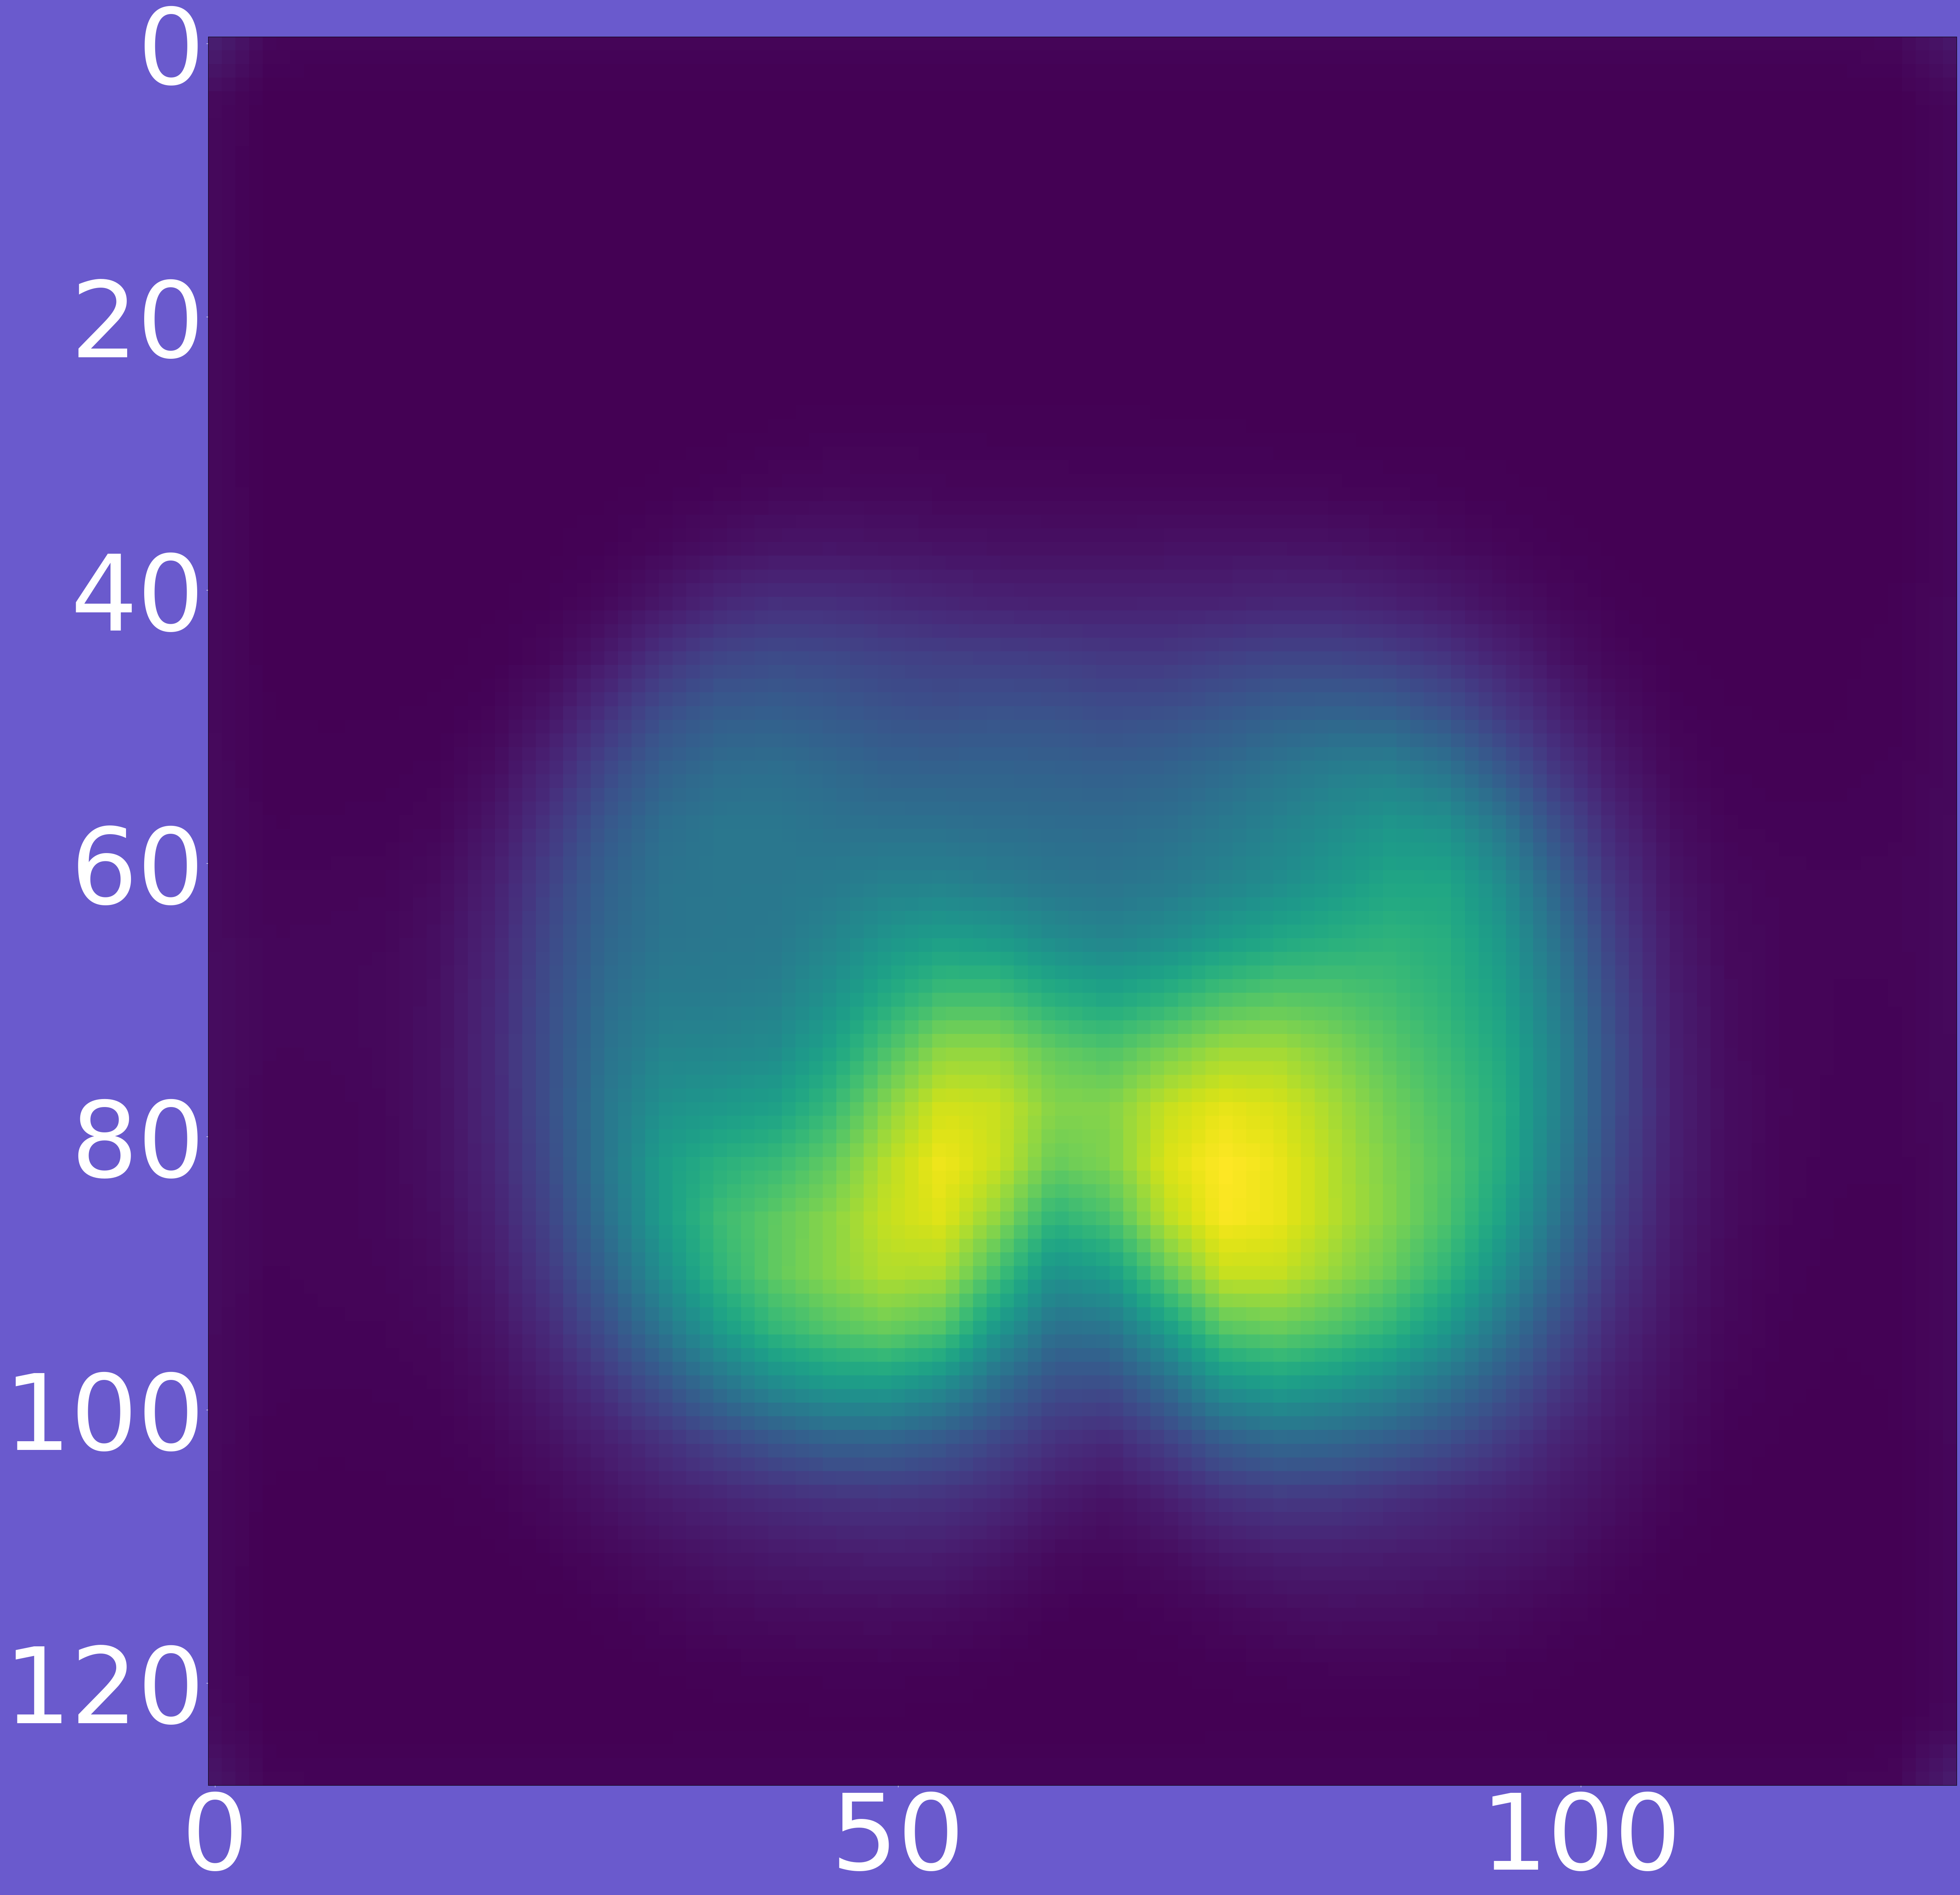

In [32]:
along_z = np.mean(along_datapoints_0, axis=2)
plt.rcParams['lines.linewidth'] = 30
fig = plt.figure(figsize=(100, 60))
fig.patch.set_facecolor('slateblue')
plt.imshow(along_z)
ax = plt.gca()
ax.tick_params(axis='x', labelsize=200, colors = 'white')
ax.tick_params(axis='y', labelsize=200, colors = 'white')

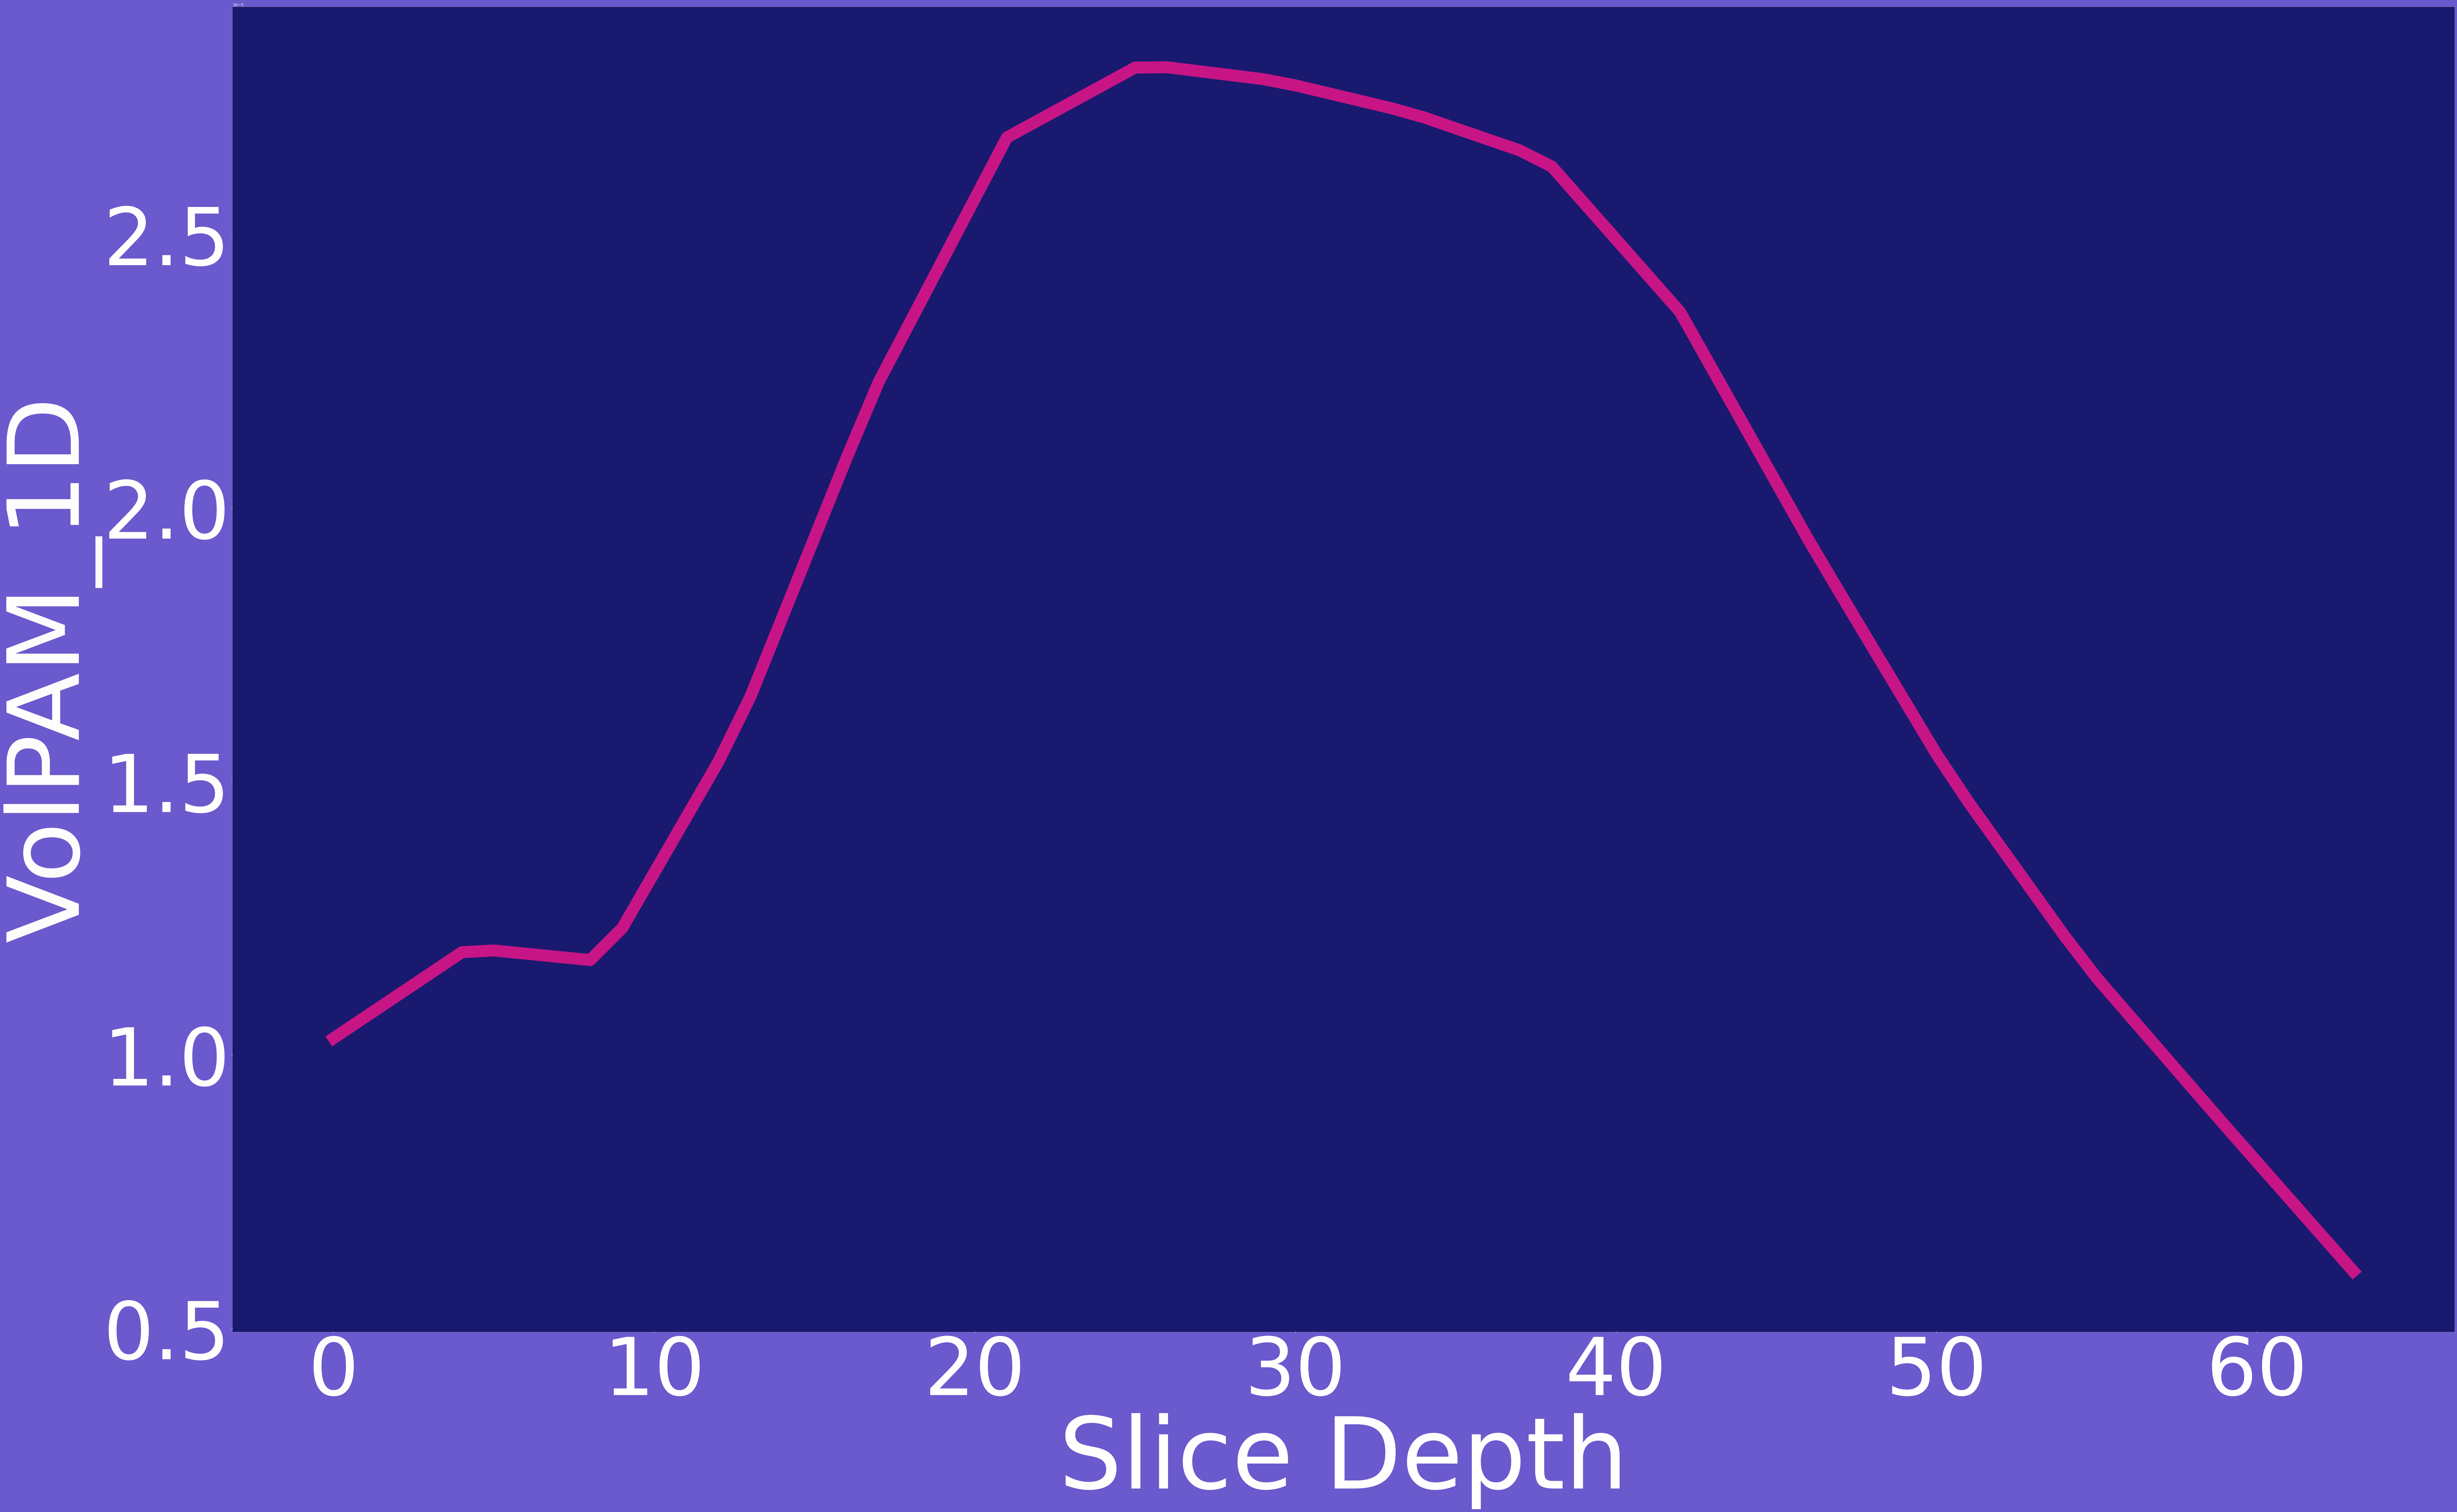

In [33]:
along_xy = along_datapoints_0.mean(axis=(0, 1))
plt.rcParams['lines.linewidth'] = 30
fig = plt.figure(figsize=(100, 60))
fig.patch.set_facecolor('slateblue')
plt.xlabel("Slice Depth", fontsize=250, color = 'white')
plt.ylabel("VolPAM_1D", fontsize=250, color = 'white')
plt.plot(along_xy, color = "mediumvioletred") # plotting by columns
ax = plt.gca()
ax.set_facecolor('midnightblue')
ax.tick_params(axis='x', labelsize=200, colors = 'white')
ax.tick_params(axis='y', labelsize=200, colors = 'white')

In [34]:
sum_mems_1 = []
imgs_cl1 = []
indx_1 = []
num_mems_1 = 0
for index, data in train_loader:
    if labels[index] == 1:
        num_mems_1 += 1
        indx_1.append(index)
        data = data.unsqueeze(1)
        # get the image from the dataloader
        main_img = data[0,...]
        main_img = main_img.cuda().detach().cpu().numpy()
        imgs_cl1.append(main_img)  
        img = data.to(device=device, dtype=torch.float) 
        winning_idx = model2(img).argmax(dim=1)
        pred = model2(img)

        # get the gradient of the output with respect to the parameters of the model
        pred[:,winning_idx].backward()

        # pull the gradients out of the model
        gradients = model2.get_activations_gradient()
        #print(gradients.shape)
        # pool the gradients across the channels
        alpha_ks = torch.mean(gradients, dim=[0, 2, 3, 4])
        #print(pooled_gradients.shape)
        # get the activations of the last convolutional layer
        weighted_combination = model2.get_activations(img).detach()
        #print(activations.shape)
        # weight the channels by corresponding gradients
        for i in range(16):
            weighted_combination[:, i, :, :, :] *= alpha_ks[i]

        # average the channels of the activations
        heatmap = torch.sum(weighted_combination, dim=1).squeeze()
        heatmap = heatmap.detach().cpu().numpy()
        heatmap = np.maximum(heatmap, 0)
        probability = pred[:,winning_idx].cuda().detach().cpu().numpy()
        heatmap *= probability
        heatmap = torch.from_numpy(heatmap)
        heatmap = heatmap.cuda().detach().cpu()
        heatmap_resized = resize_heat(heatmap)
        sum_mems_1.append(heatmap_resized)       
        
sum_mems_1 = np.stack(sum_mems_1)
sum_mems_1 /= num_mems_1
imgs_cl1 = np.stack(imgs_cl1)
indx_1 = np.stack(indx_1)

In [35]:
img_means = np.mean(imgs_cl1, 0)
print(img_means.shape)
resh_vol = np.reshape( imgs_cl1, [imgs_cl1.shape[0],-1])
print(resh_vol.shape)
resh_mean = np.reshape( img_means, [1,-1])
print(resh_mean.shape)
dist_matrix = get_distance_matrix(resh_vol, resh_mean)
print(dist_matrix.shape)

# initialize K
K = 10
  
# Smallest K elements indices
# using sorted() + lambda + list slicing
res = sorted(range(len(dist_matrix)), key = lambda sub: dist_matrix[sub])[:K]

closest_to_mean_1 = [indx_1[i] for i in res]

(1, 128, 128, 64)
(296, 1048576)
(1, 1048576)
(296, 1)


In [36]:
along_datapoints_1 = np.mean(sum_mems_1, axis=0)
print(along_datapoints_1.shape)

(128, 128, 64)


In [37]:
main_img_avg_cl1 = np.mean(imgs_cl1, axis=0)
main_img_avg_cl1 = main_img_avg_cl1[0,:,:,:]
superimposed_img_1 = along_datapoints_1 + main_img_avg_cl1

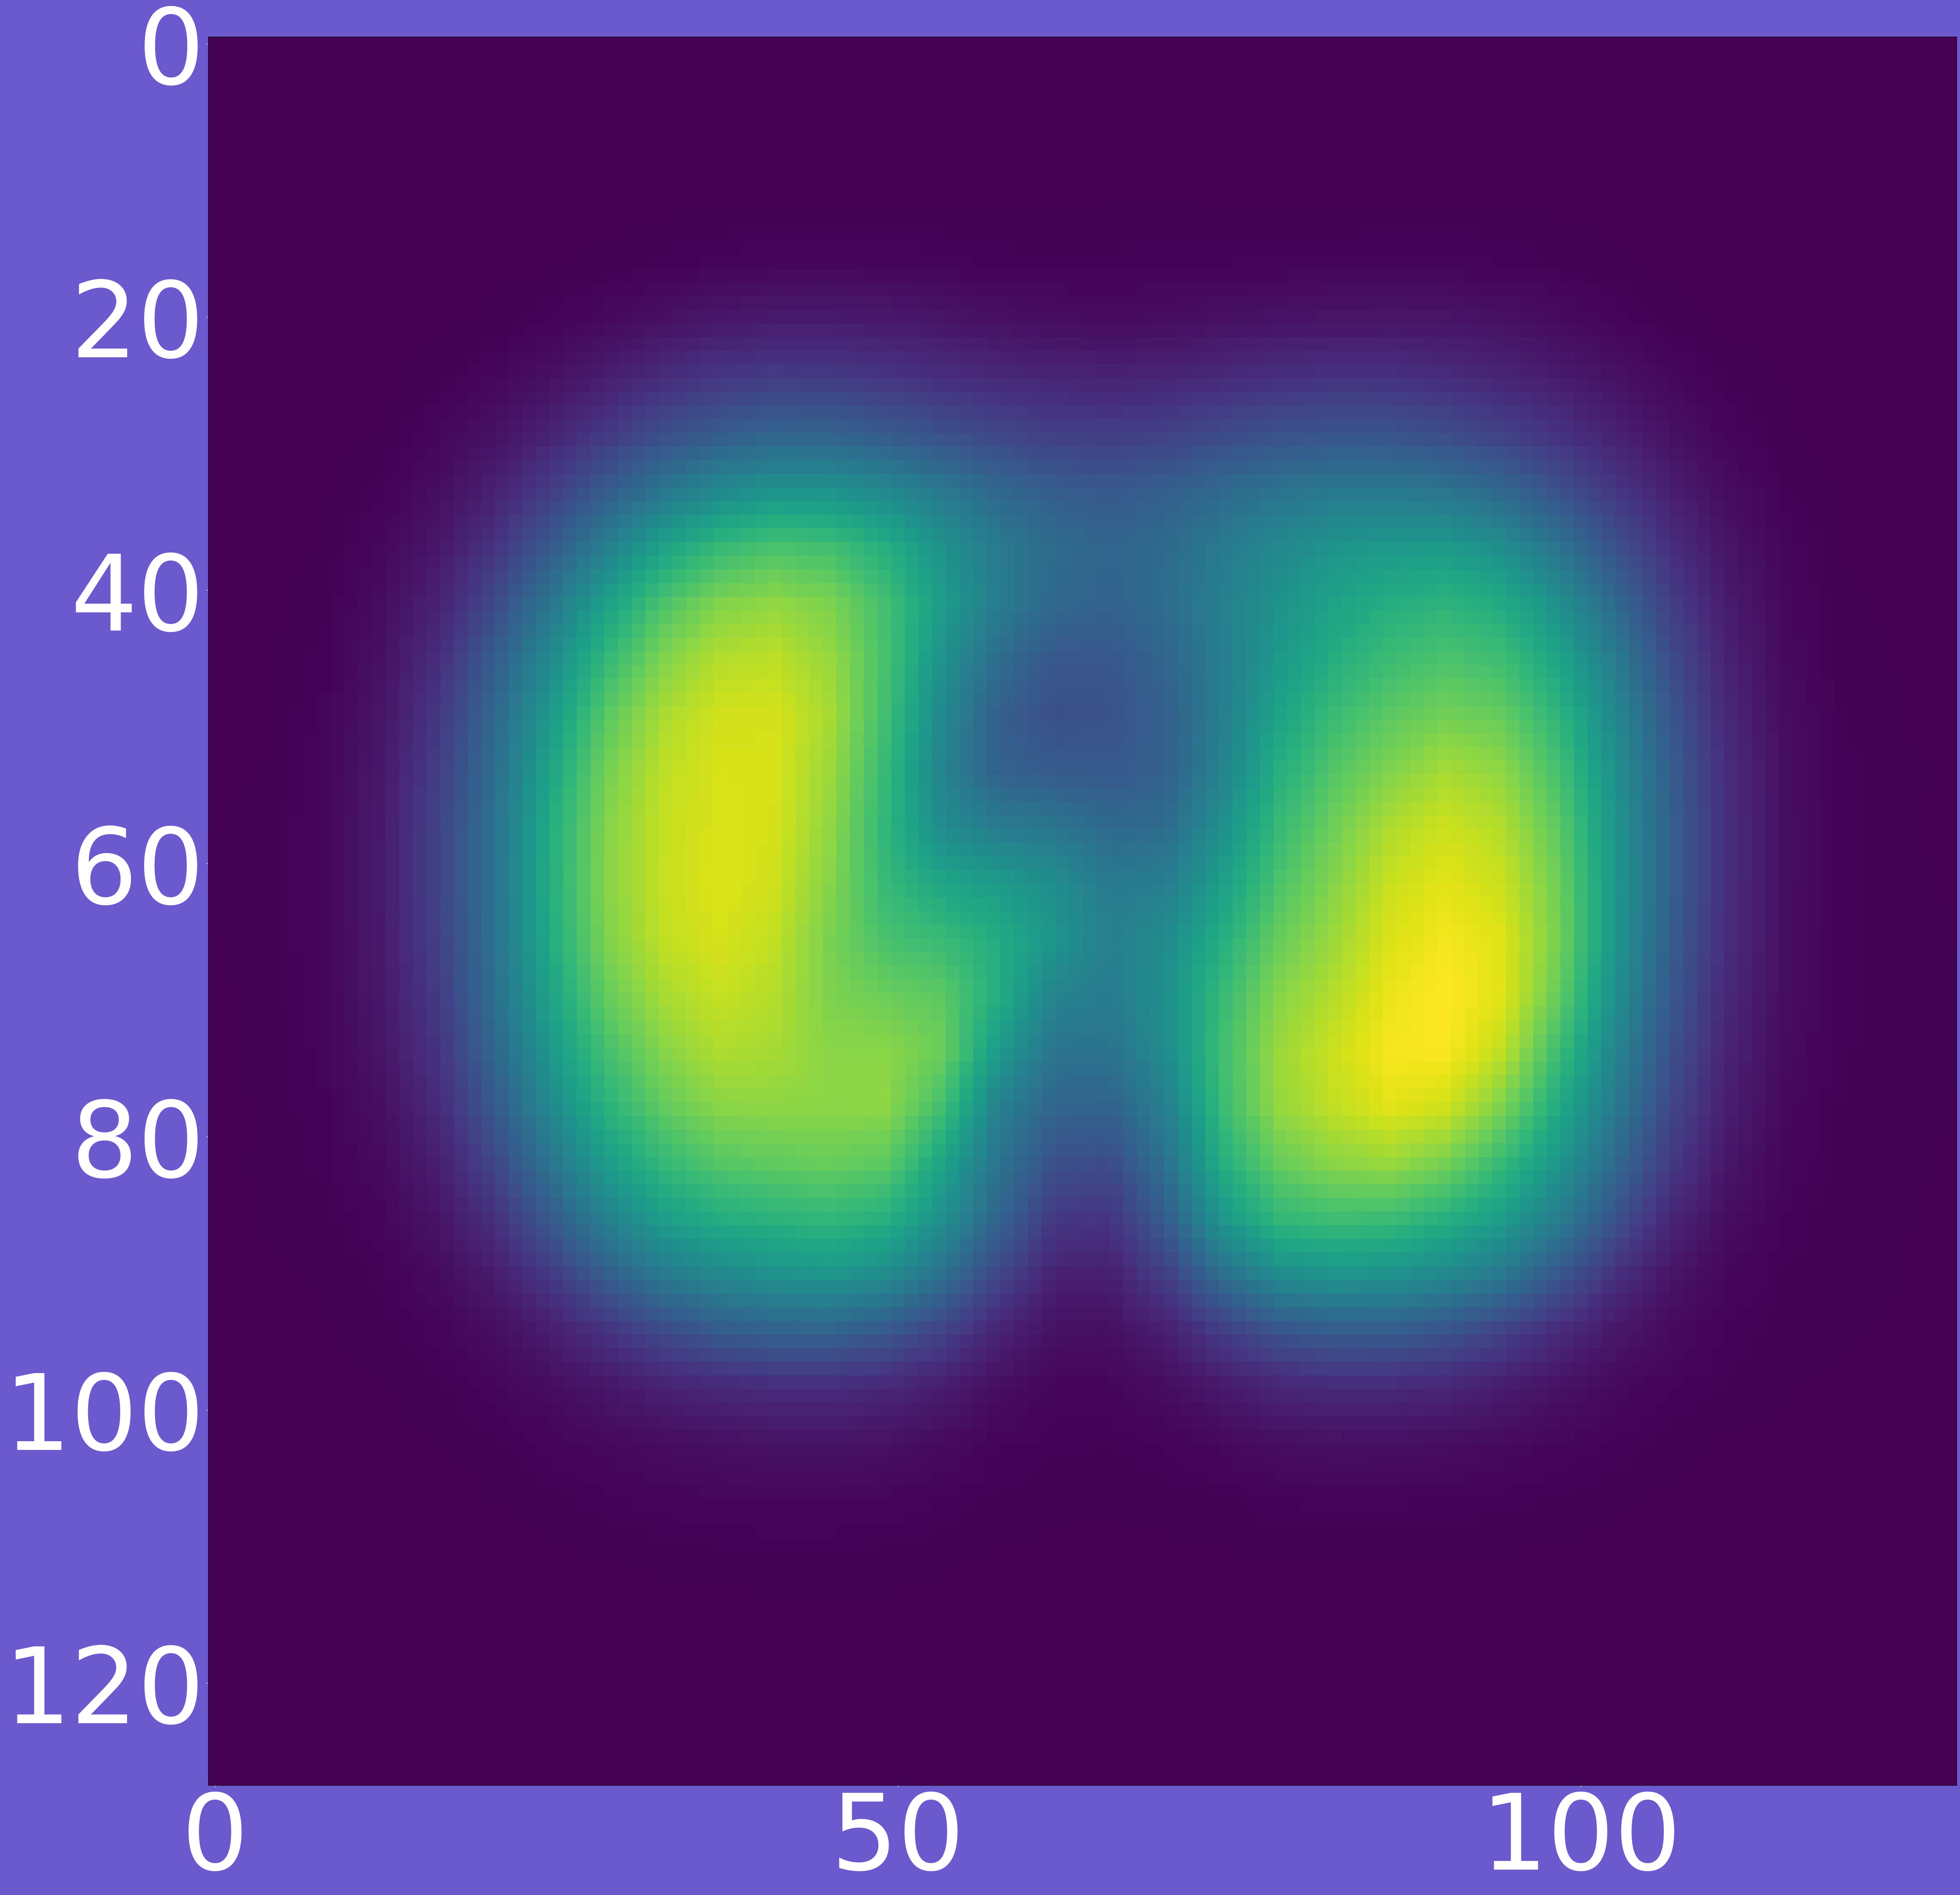

In [38]:
along_z = np.mean(along_datapoints_1, axis=2)
plt.rcParams['lines.linewidth'] = 30
fig = plt.figure(figsize=(100, 60))
fig.patch.set_facecolor('slateblue')
plt.imshow(along_z)
ax = plt.gca()
ax.tick_params(axis='x', labelsize=200, colors = 'white')
ax.tick_params(axis='y', labelsize=200, colors = 'white')

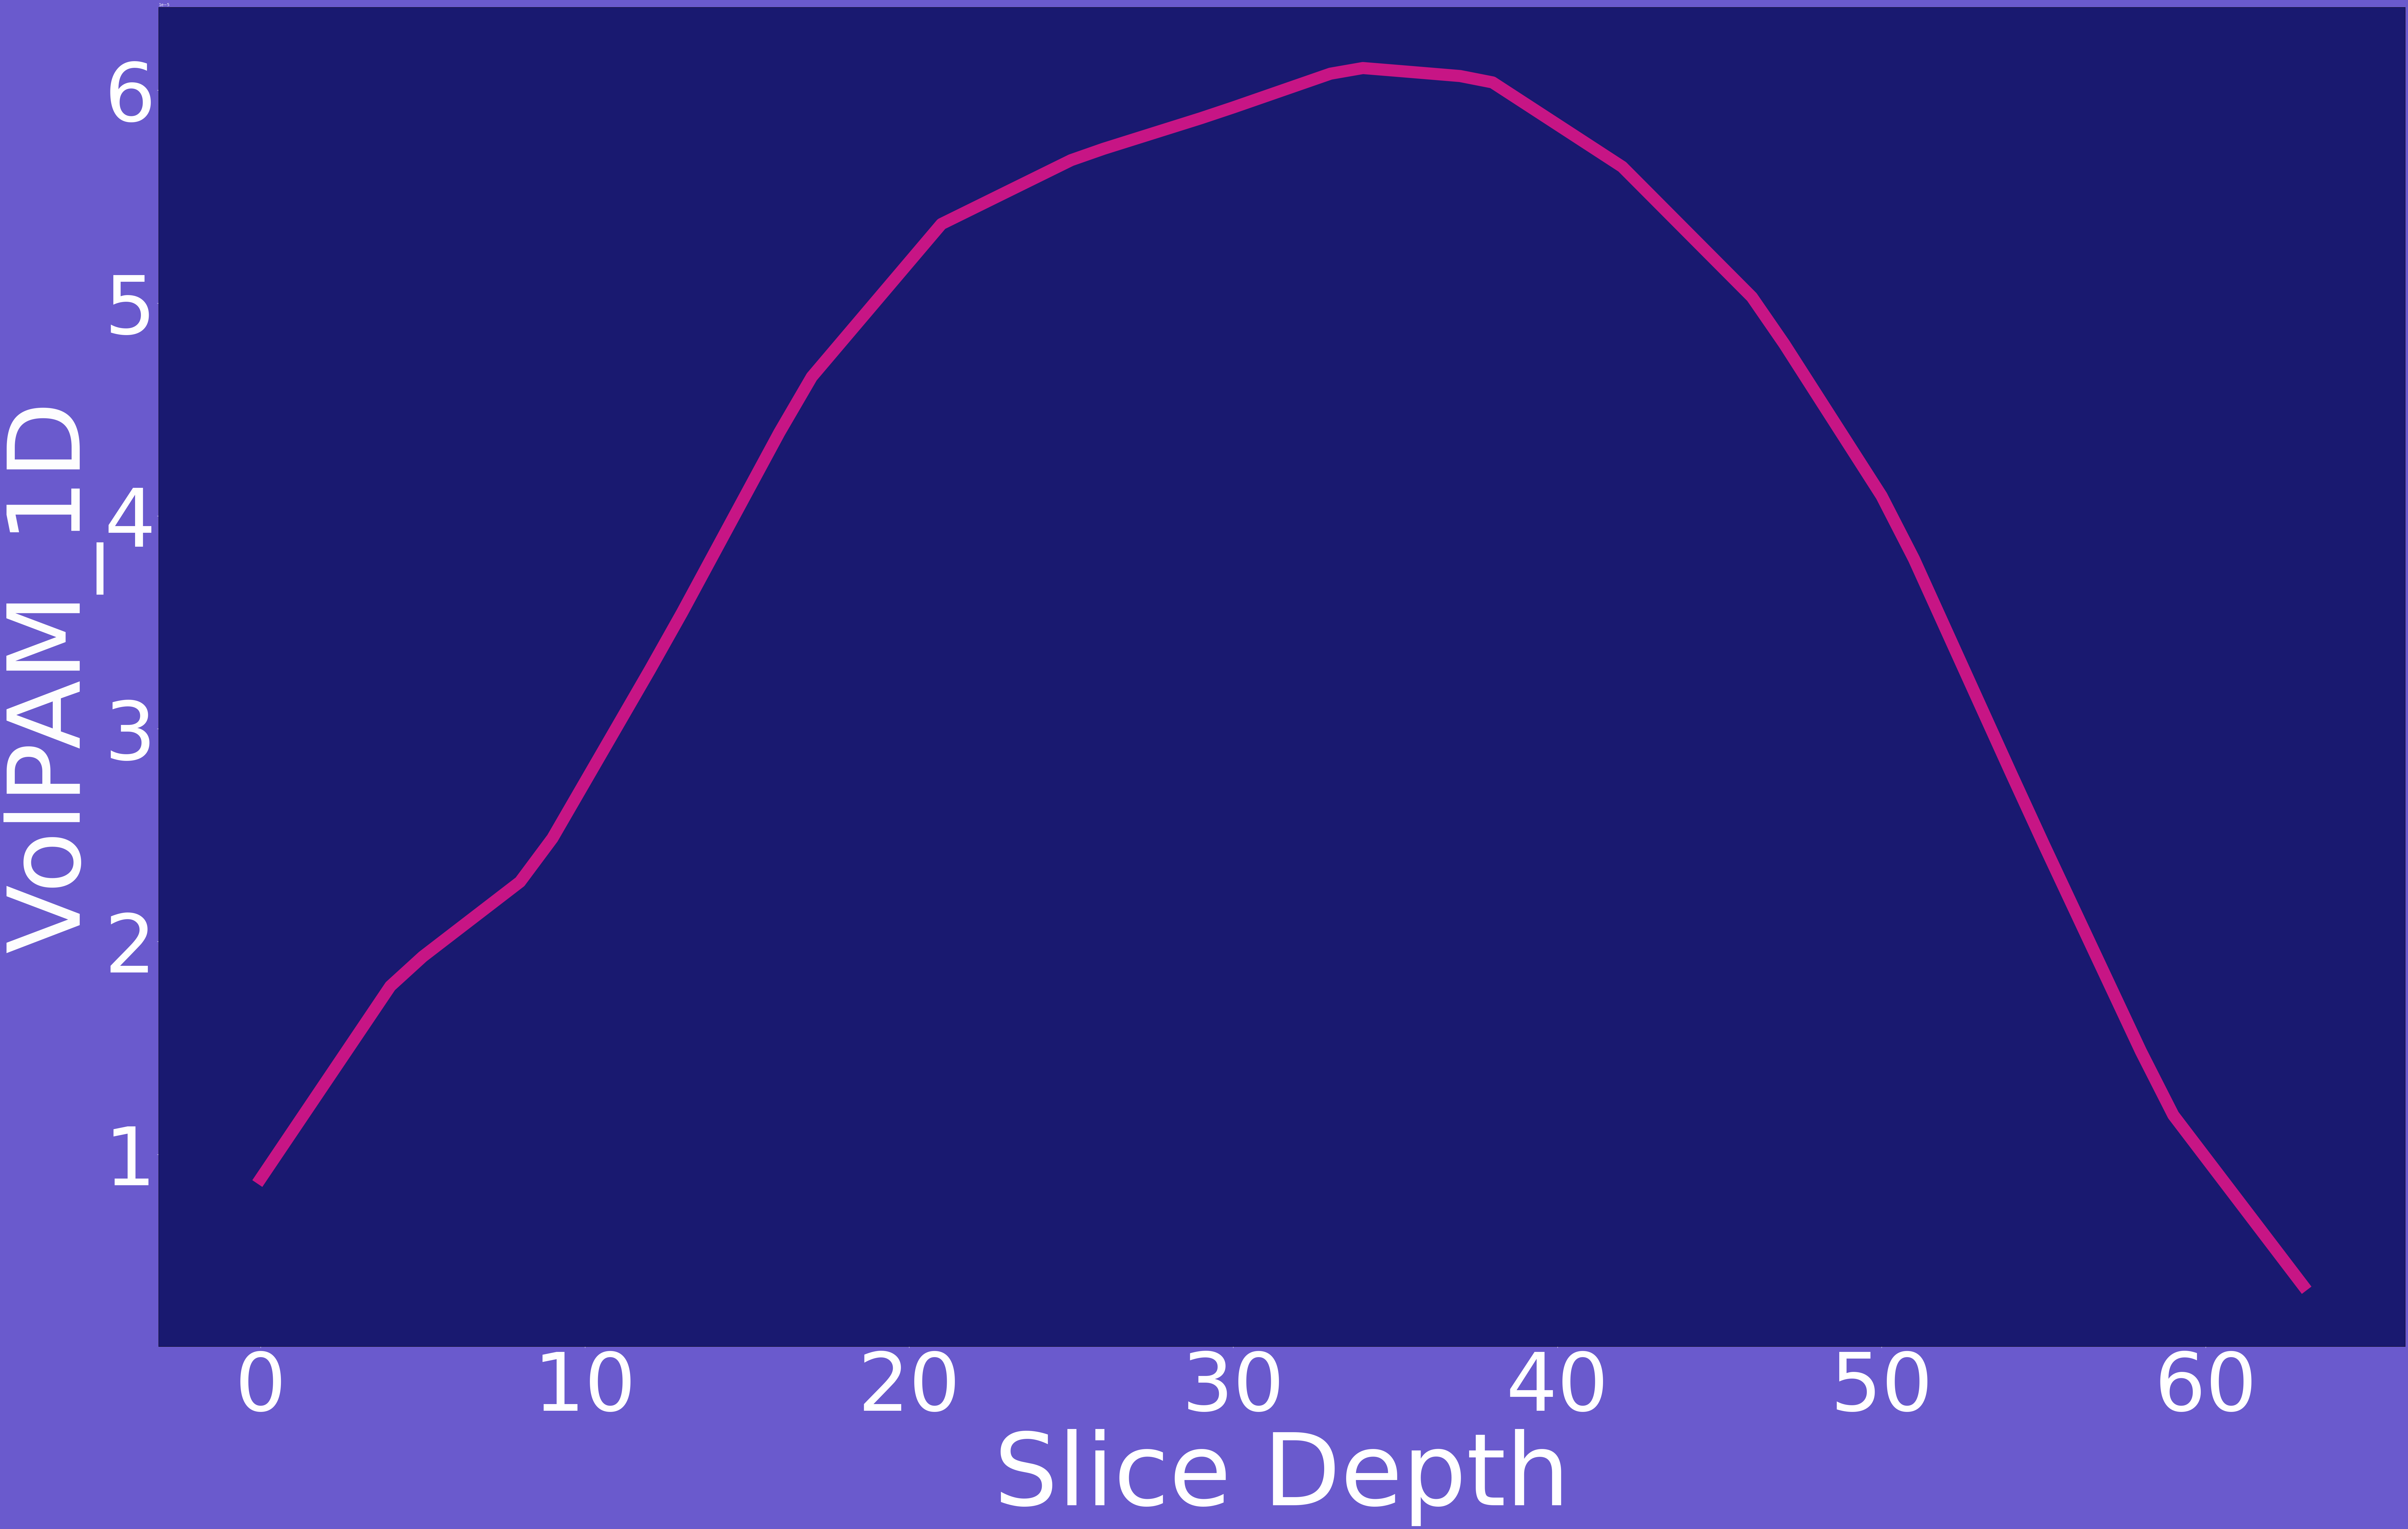

In [39]:
along_xy = along_datapoints_1.mean(axis=(0, 1))
plt.rcParams['lines.linewidth'] = 30
fig = plt.figure(figsize=(100, 60))
fig.patch.set_facecolor('slateblue')
plt.xlabel("Slice Depth", fontsize=250, color = 'white')
plt.ylabel("VolPAM_1D", fontsize=250, color = 'white')
plt.plot(along_xy, color = "mediumvioletred") # plotting by columns
ax = plt.gca()
ax.set_facecolor('midnightblue')
ax.tick_params(axis='x', labelsize=200, colors = 'white')
ax.tick_params(axis='y', labelsize=200, colors = 'white')

In [40]:
sum_mems_2 = []
imgs_cl2 = []
indx_2 = []
num_mems_2 = 0
for index, data in train_loader:
    if labels[index] == 2:
        indx_2.append(index) 
        num_mems_2 += 1
        data = data.unsqueeze(1)
        # get the image from the dataloader
        main_img = data[0,...]
        main_img = main_img.cuda().detach().cpu().numpy()
        imgs_cl2.append(main_img)  
        img = data.to(device=device, dtype=torch.float) 
        winning_idx = model2(img).argmax(dim=1)
        pred = model2(img)

        # get the gradient of the output with respect to the parameters of the model
        pred[:,winning_idx].backward()

        # pull the gradients out of the model
        gradients = model2.get_activations_gradient()
        #print(gradients.shape)
        # pool the gradients across the channels
        alpha_ks = torch.mean(gradients, dim=[0, 2, 3, 4])
        #print(pooled_gradients.shape)
        # get the activations of the last convolutional layer
        weighted_combination = model2.get_activations(img).detach()
        #print(activations.shape)
        # weight the channels by corresponding gradients
        for i in range(16):
            weighted_combination[:, i, :, :, :] *= alpha_ks[i]

        # average the channels of the activations
        heatmap = torch.sum(weighted_combination, dim=1).squeeze()
        heatmap = heatmap.detach().cpu().numpy()
        heatmap = np.maximum(heatmap, 0)
        probability = pred[:,winning_idx].cuda().detach().cpu().numpy()
        heatmap *= probability
        heatmap = torch.from_numpy(heatmap)
        heatmap = heatmap.cuda().detach().cpu()
        heatmap_resized = resize_heat(heatmap)
        sum_mems_2.append(heatmap_resized)       
        
sum_mems_2 = np.stack(sum_mems_2)
sum_mems_2 /= num_mems_2
imgs_cl2 = np.stack(imgs_cl2)
indx_2 = np.stack(indx_2)

In [41]:
img_means = np.mean(imgs_cl2, 0)
print(img_means.shape)
resh_vol = np.reshape( imgs_cl2, [imgs_cl2.shape[0],-1])
print(resh_vol.shape)
resh_mean = np.reshape( img_means, [1,-1])
print(resh_mean.shape)
dist_matrix = get_distance_matrix(resh_vol, resh_mean)
print(dist_matrix.shape)

# initialize K
K = 10
  
# Smallest K elements indices
# using sorted() + lambda + list slicing
res = sorted(range(len(dist_matrix)), key = lambda sub: dist_matrix[sub])[:K]

closest_to_mean_2 = [indx_2[i] for i in res]

(1, 128, 128, 64)
(221, 1048576)
(1, 1048576)
(221, 1)


In [42]:
along_datapoints_2 = np.mean(sum_mems_2, axis=0)
print(along_datapoints_2.shape)

(128, 128, 64)


In [43]:
main_img_avg_cl2 = np.mean(imgs_cl2, axis=0)
main_img_avg_cl2 = main_img_avg_cl2[0,:,:,:]
superimposed_img_2 = along_datapoints_2 + main_img_avg_cl2

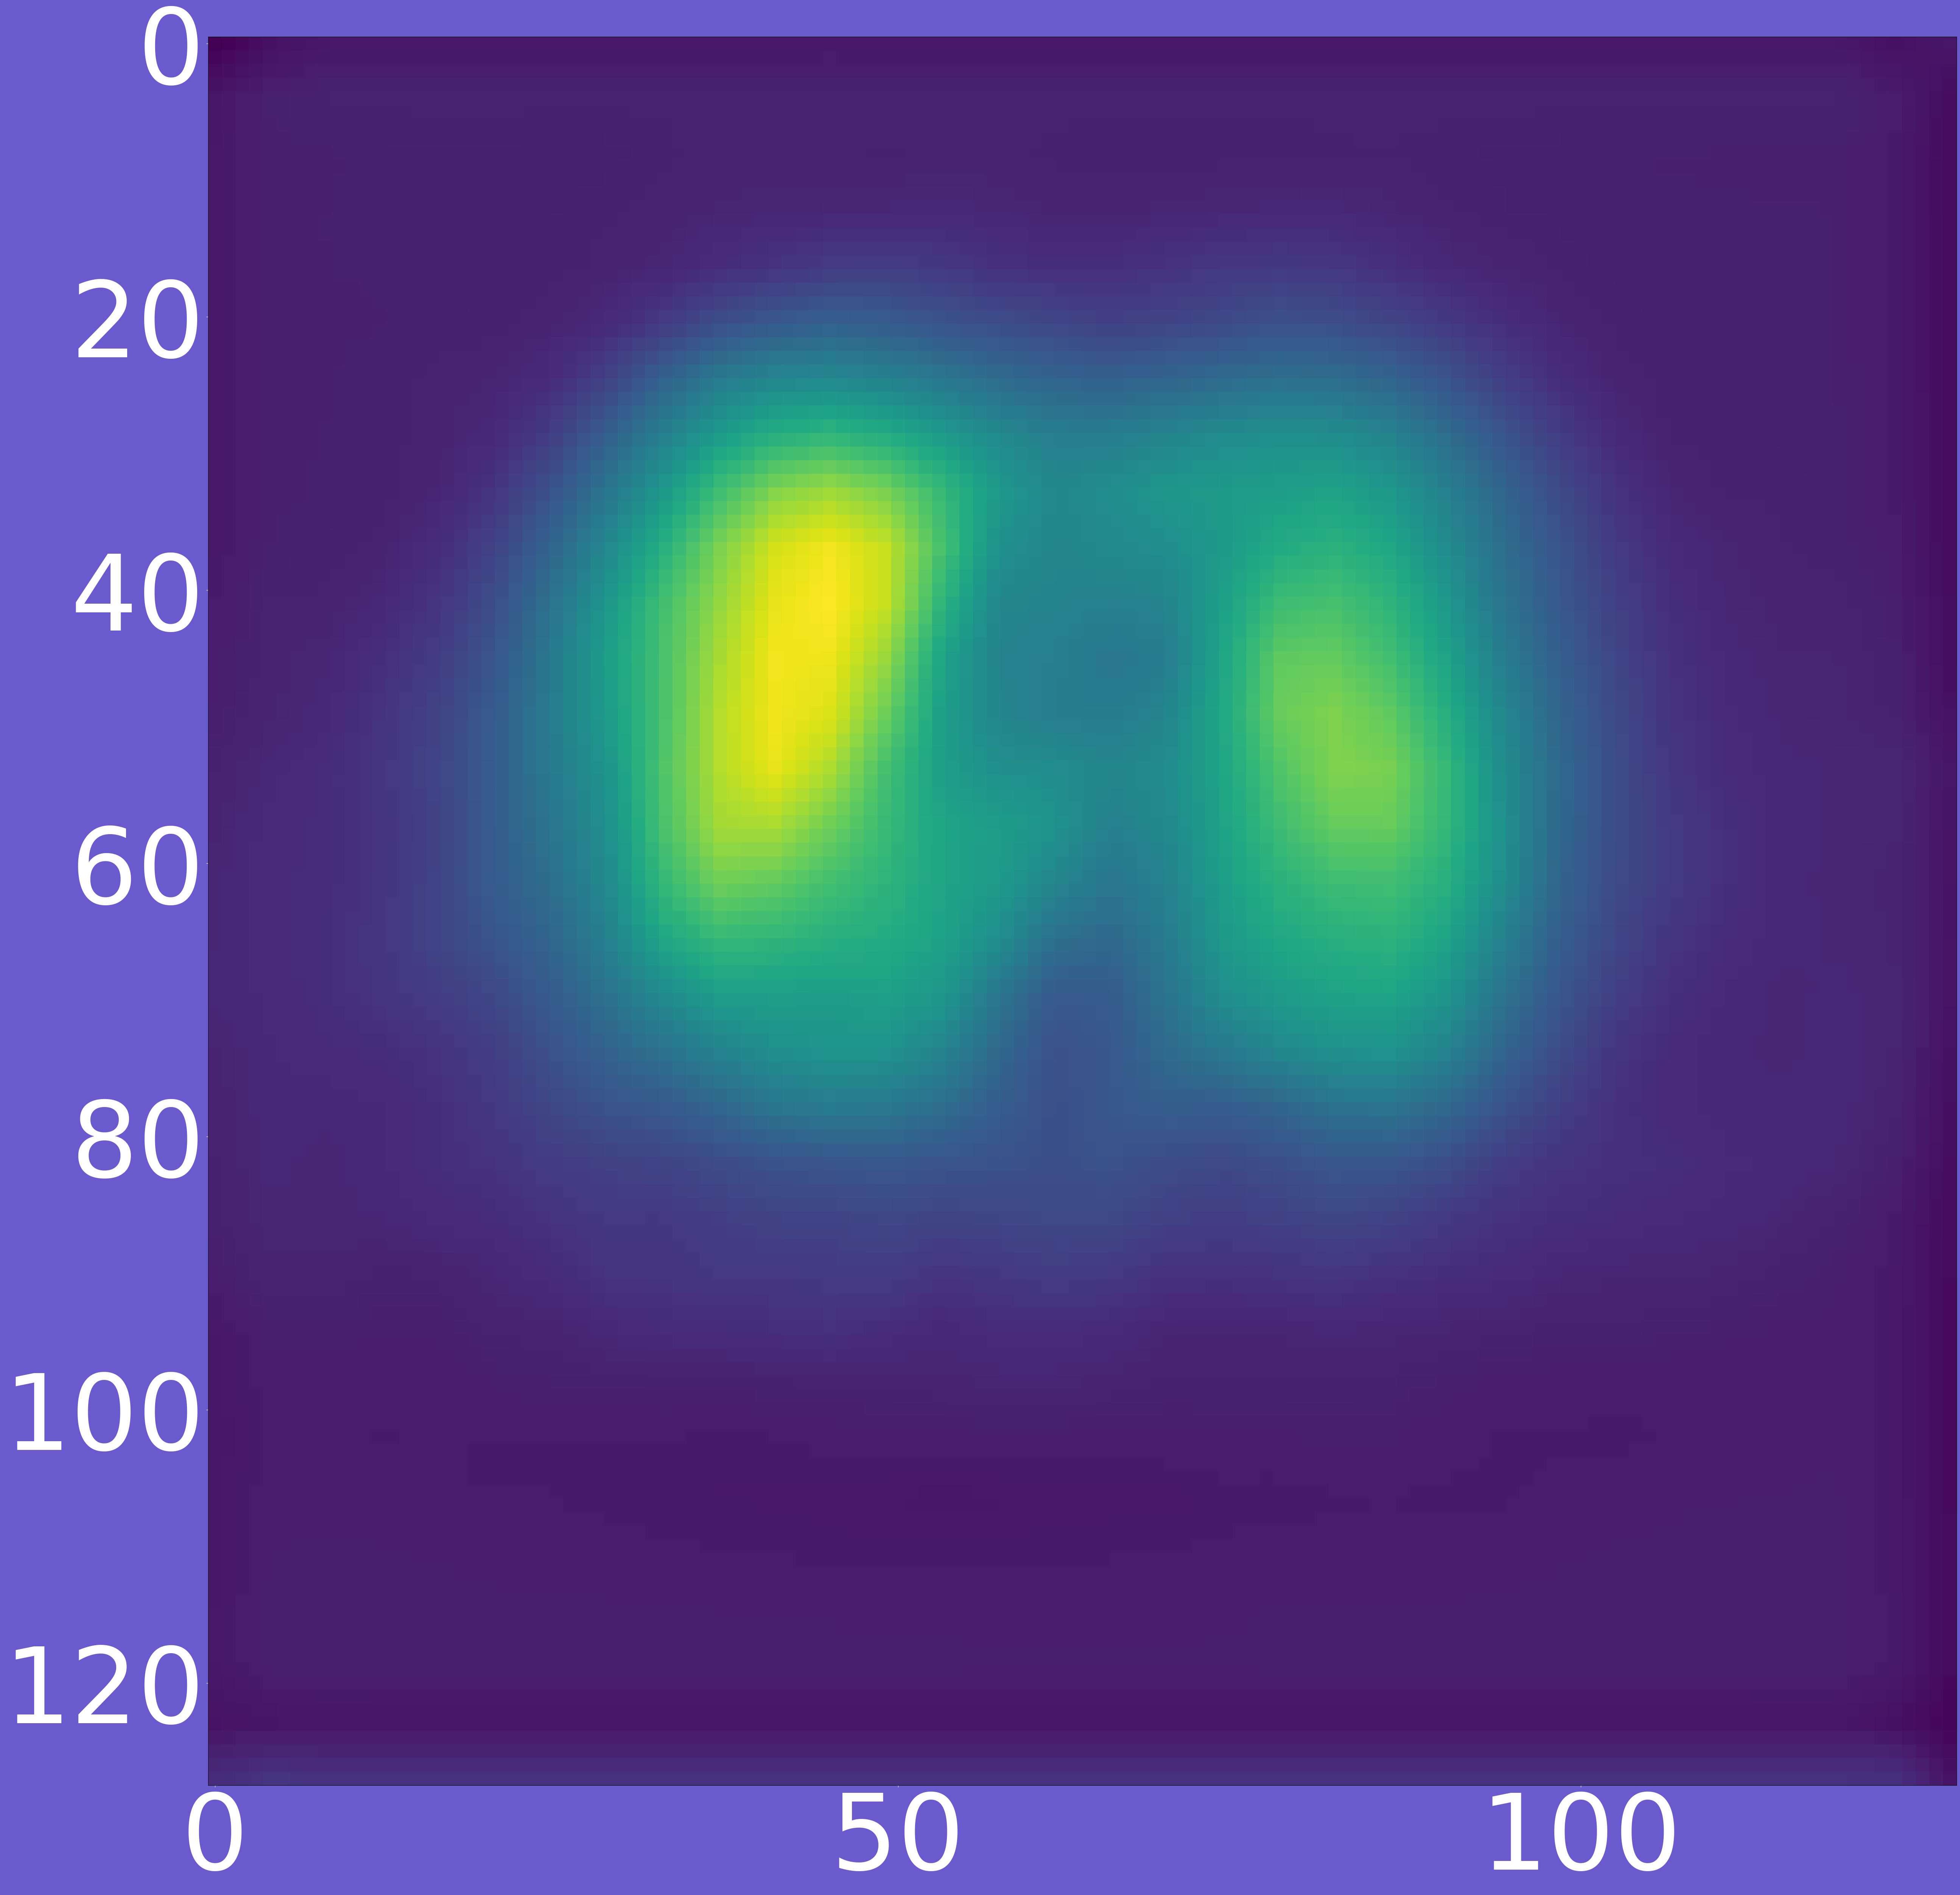

In [44]:
along_z = np.mean(along_datapoints_2, axis=2)
plt.rcParams['lines.linewidth'] = 30
fig = plt.figure(figsize=(100, 60))
fig.patch.set_facecolor('slateblue')
plt.imshow(along_z)
ax = plt.gca()
ax.tick_params(axis='x', labelsize=200, colors = 'white')
ax.tick_params(axis='y', labelsize=200, colors = 'white')

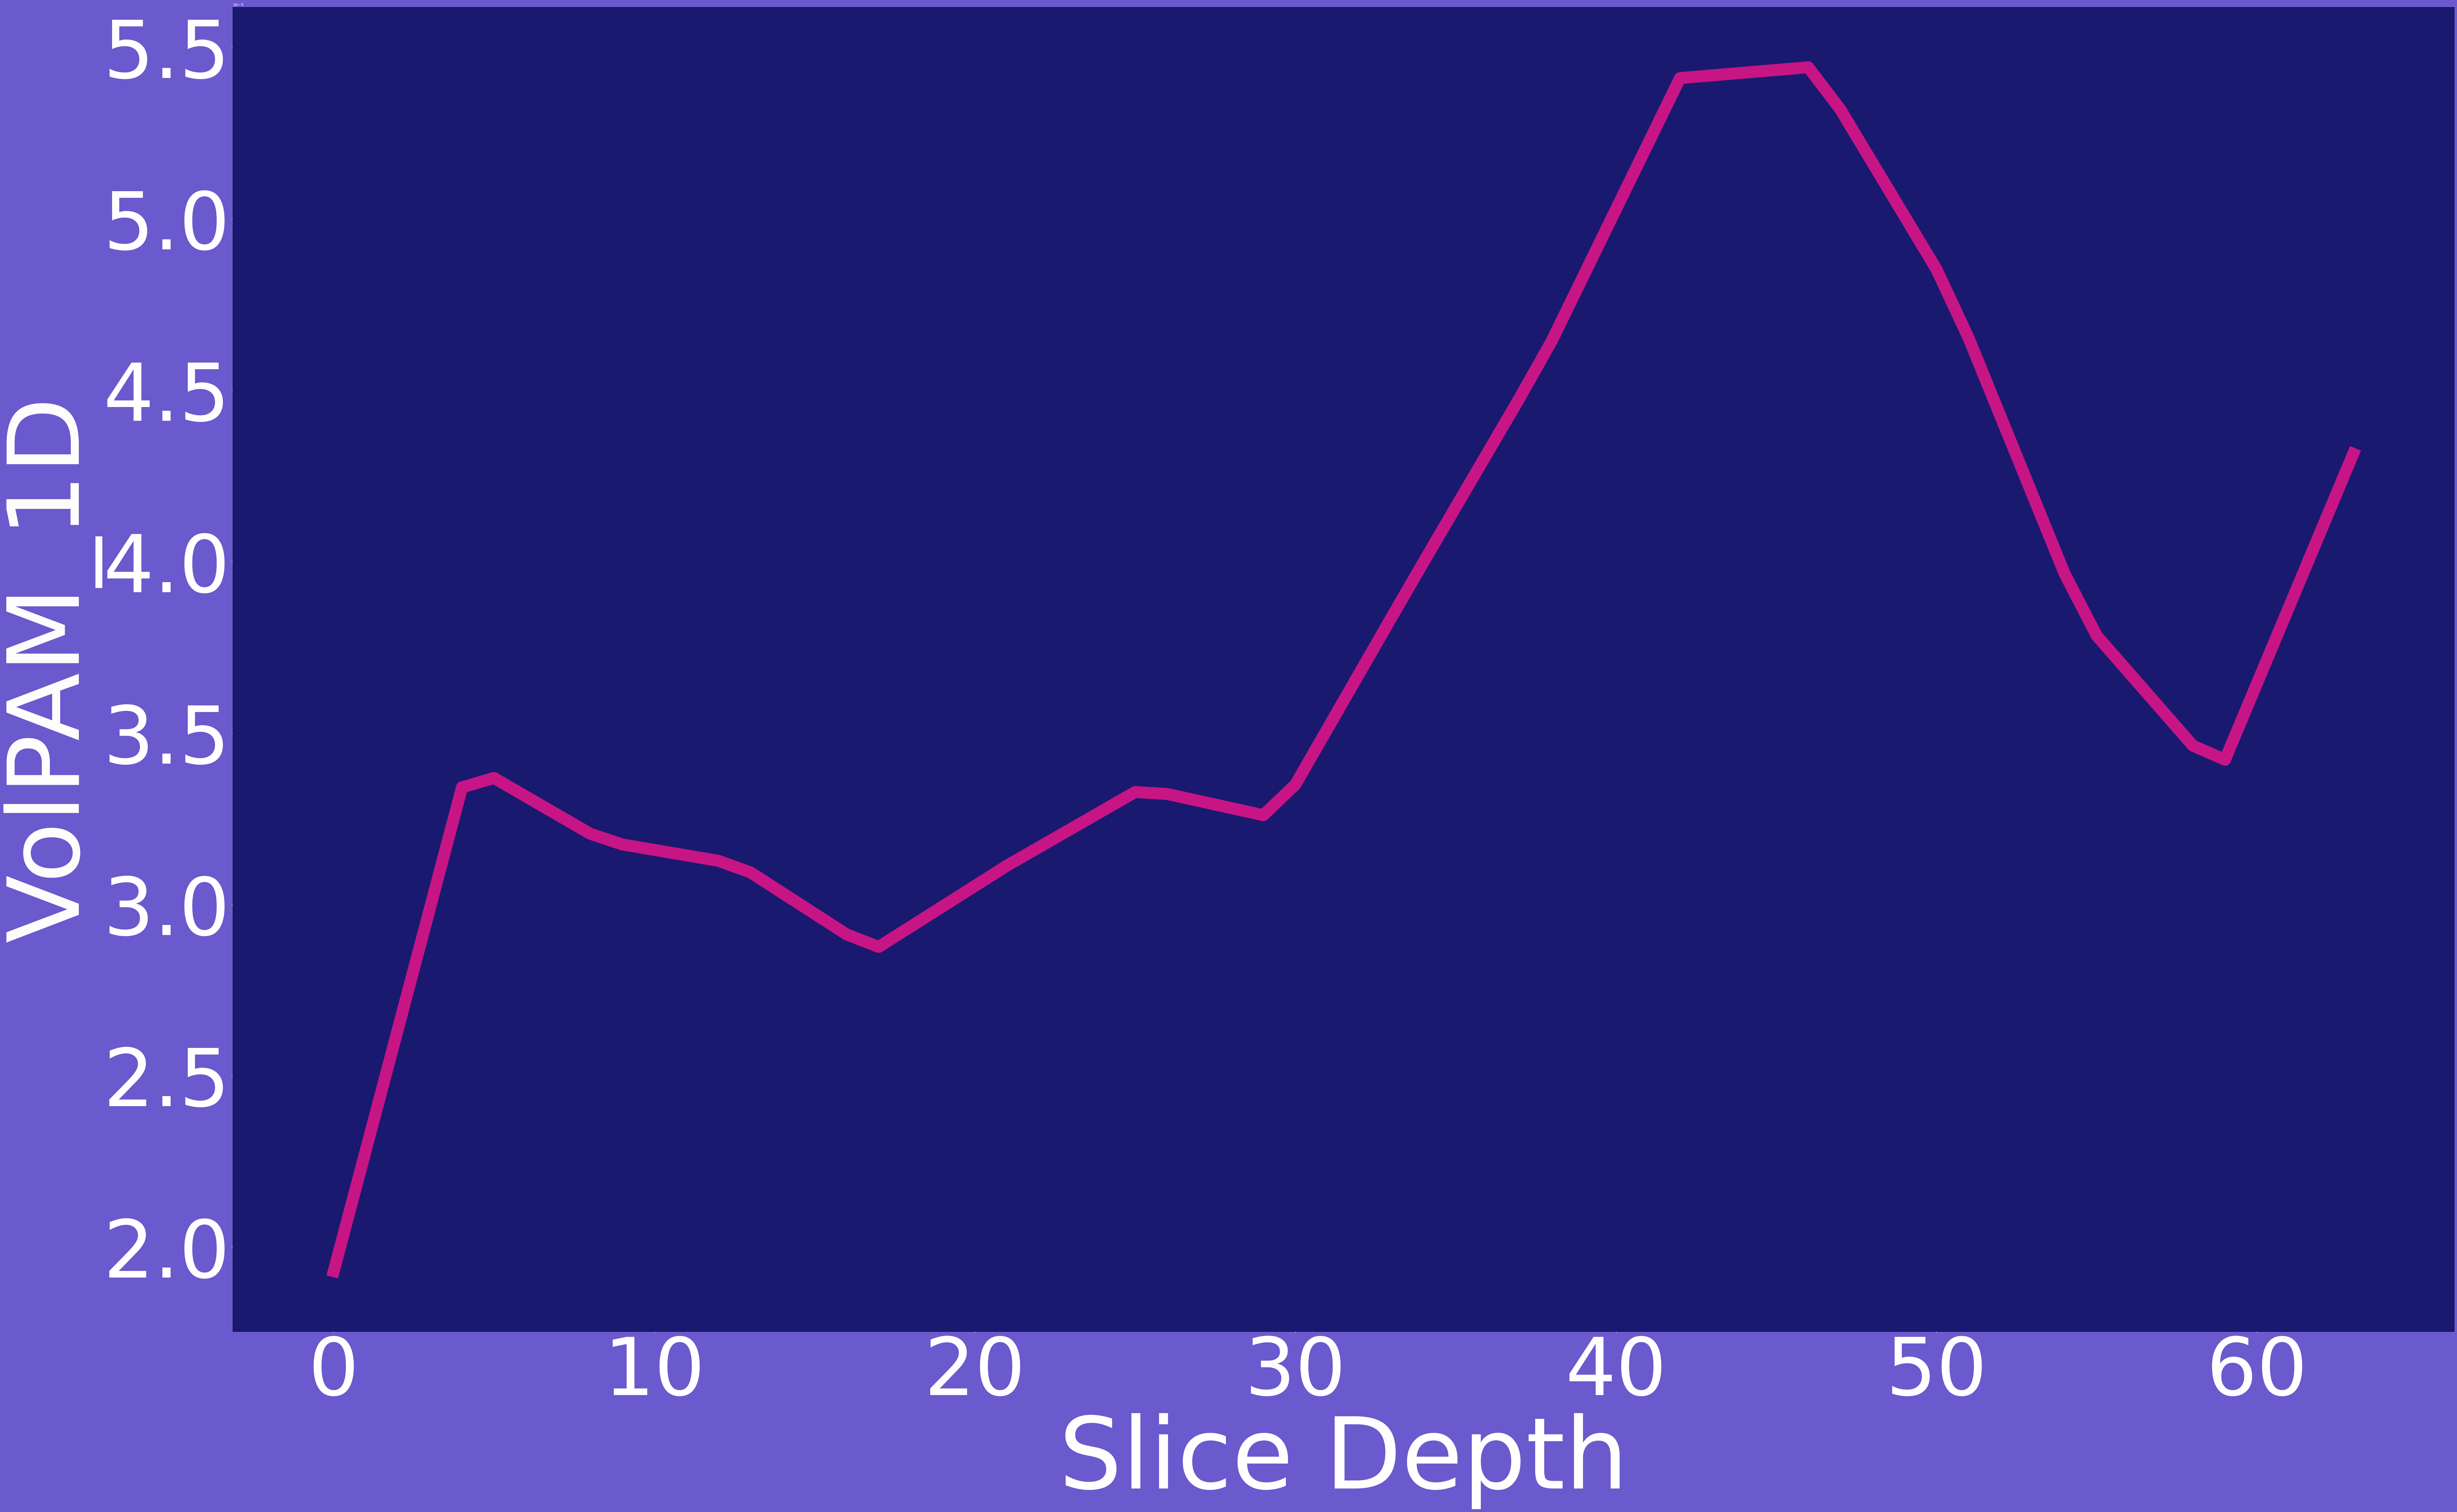

In [45]:
along_xy = along_datapoints_2.mean(axis=(0, 1))
plt.rcParams['lines.linewidth'] = 30
fig = plt.figure(figsize=(100, 60))
fig.patch.set_facecolor('slateblue')
plt.xlabel("Slice Depth", fontsize=250, color = 'white')
plt.ylabel("VolPAM_1D", fontsize=250, color = 'white')
plt.plot(along_xy, color = "mediumvioletred") # plotting by columns
ax = plt.gca()
ax.set_facecolor('midnightblue')
ax.tick_params(axis='x', labelsize=200, colors = 'white')
ax.tick_params(axis='y', labelsize=200, colors = 'white')

In [46]:
close0 = [mainVol[i] for i in closest_to_mean_0]
close1 = [mainVol[i] for i in closest_to_mean_1]
close2 = [mainVol[i] for i in closest_to_mean_2]

In [47]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

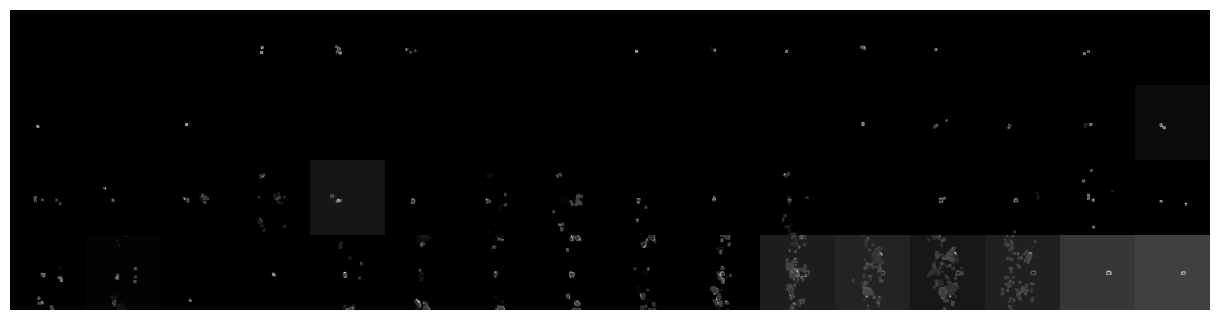

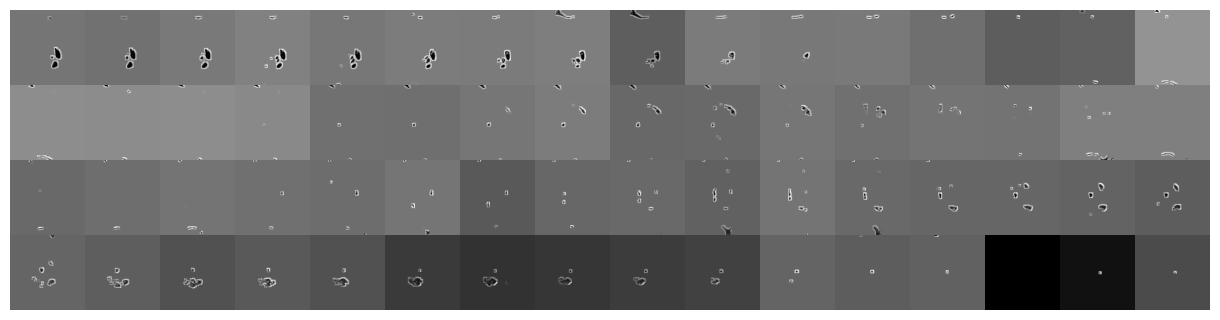

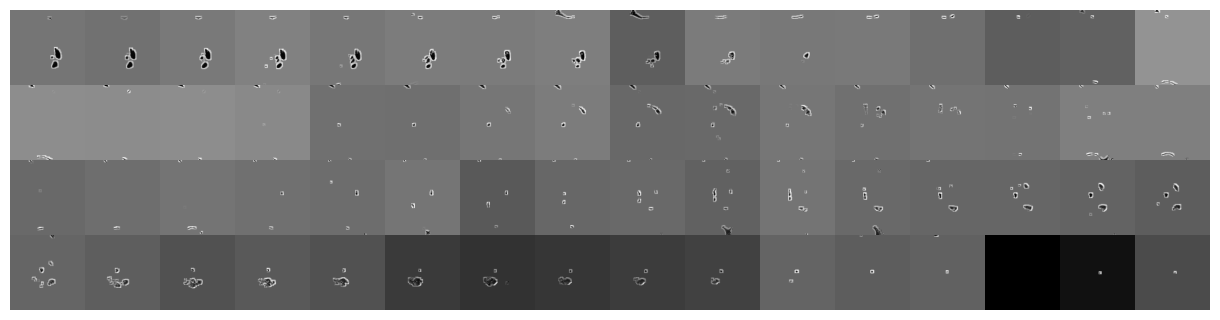

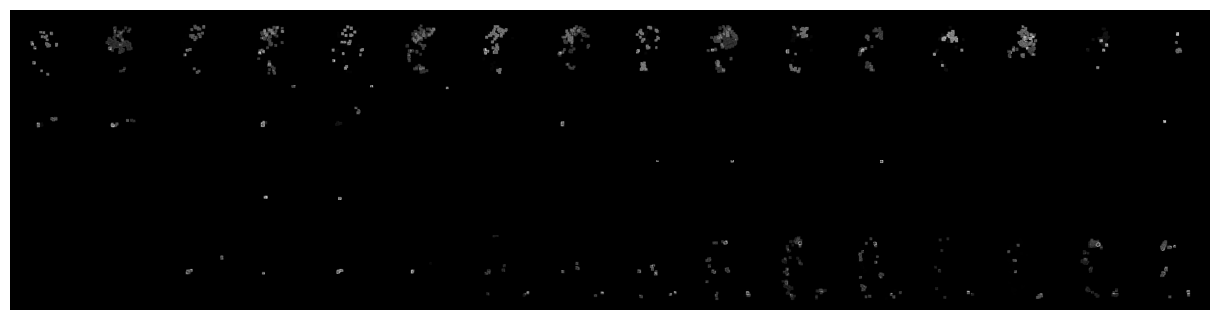

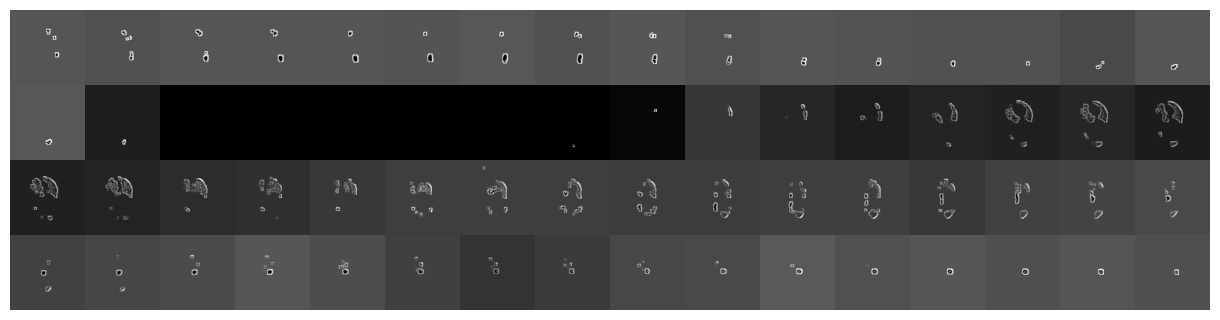

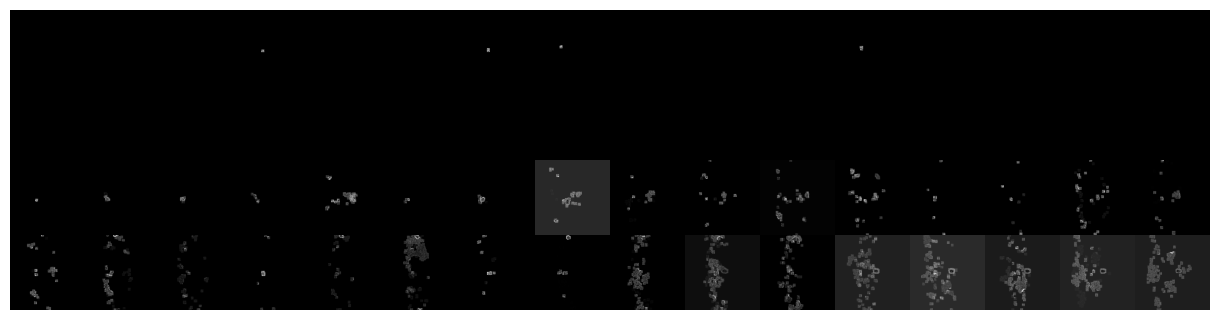

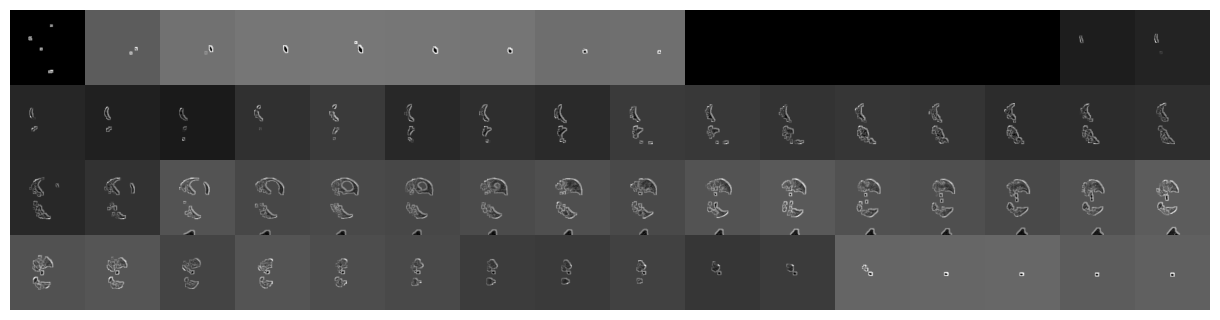

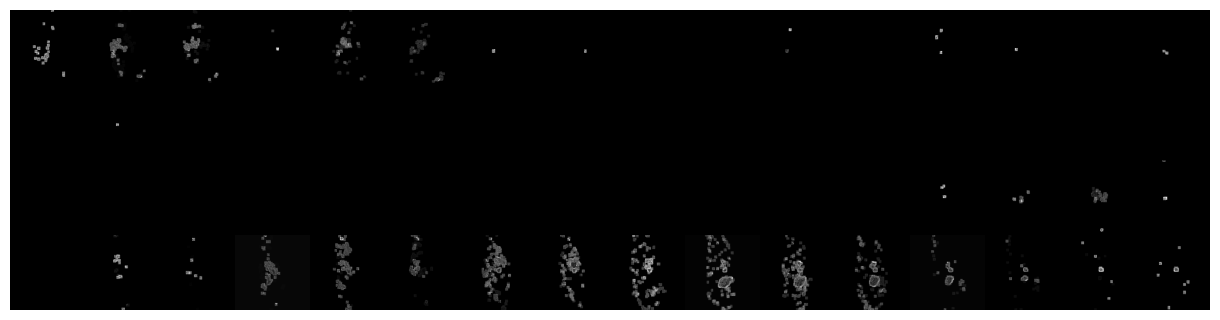

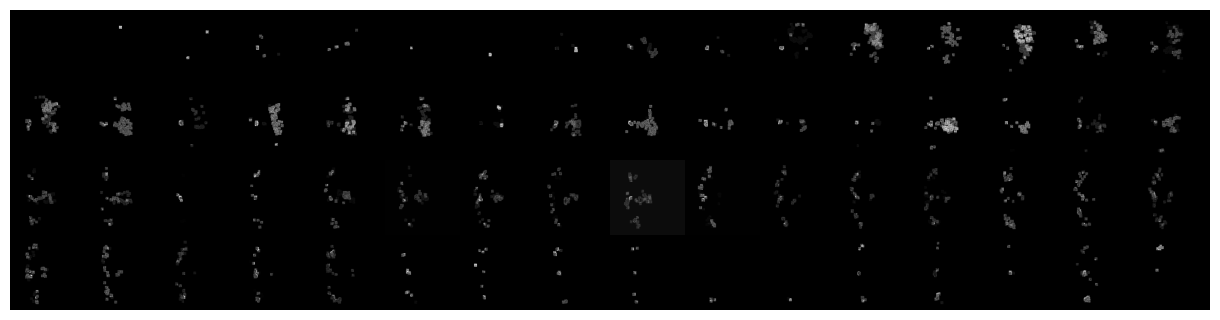

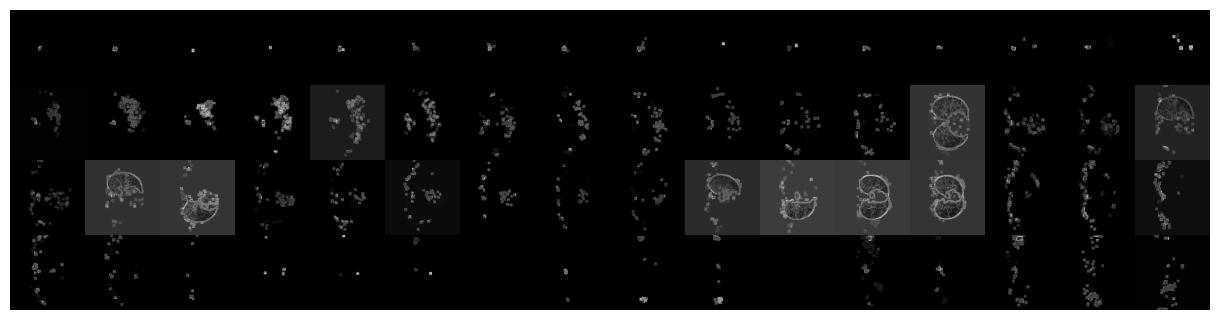

In [48]:
for i in range(np.shape(close0)[0]):
    plot_slices(4, 16, 128, 128, np.array(close0)[i,:,:,:])
    plt.show() 

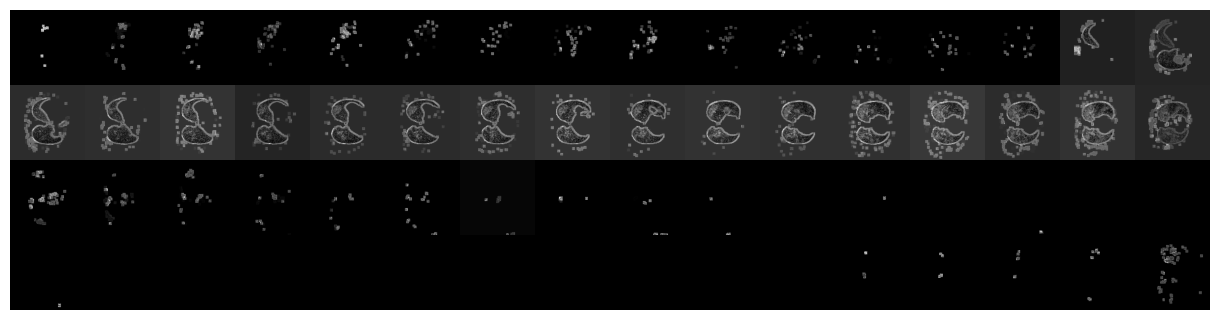

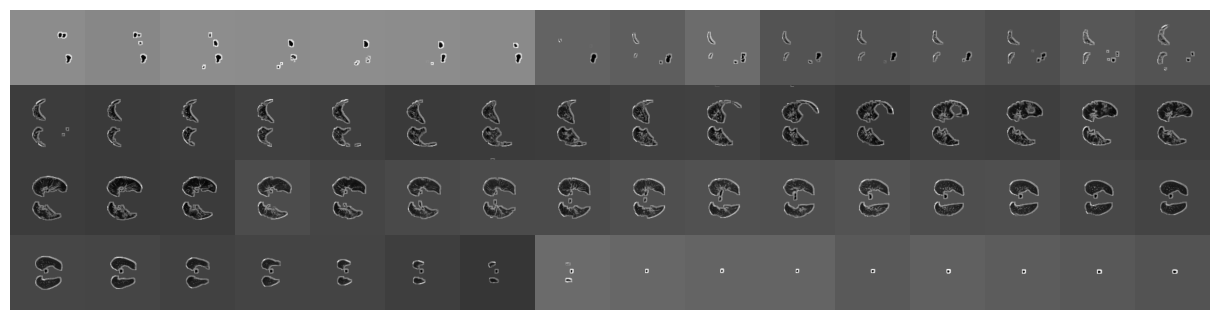

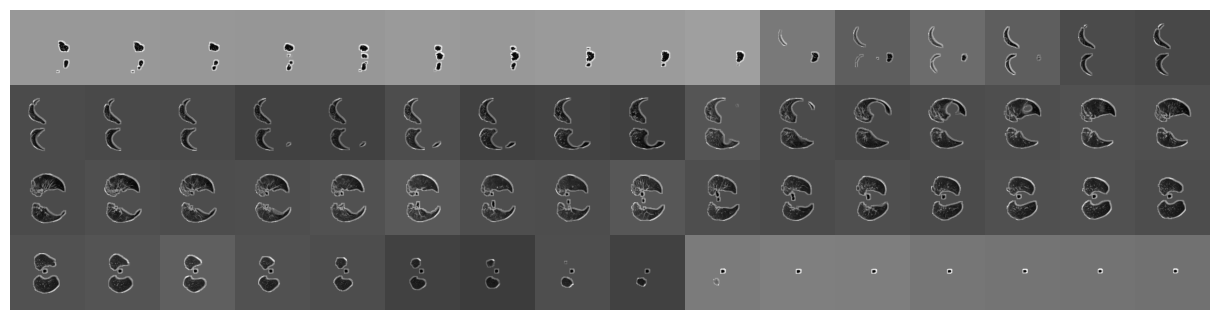

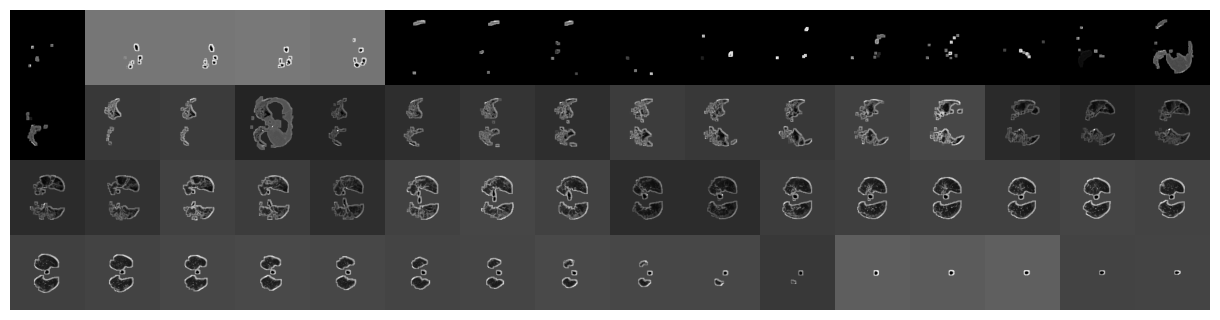

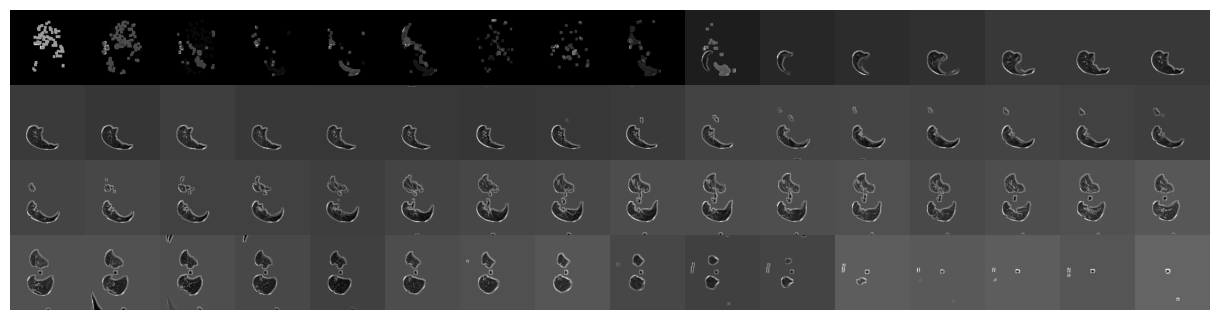

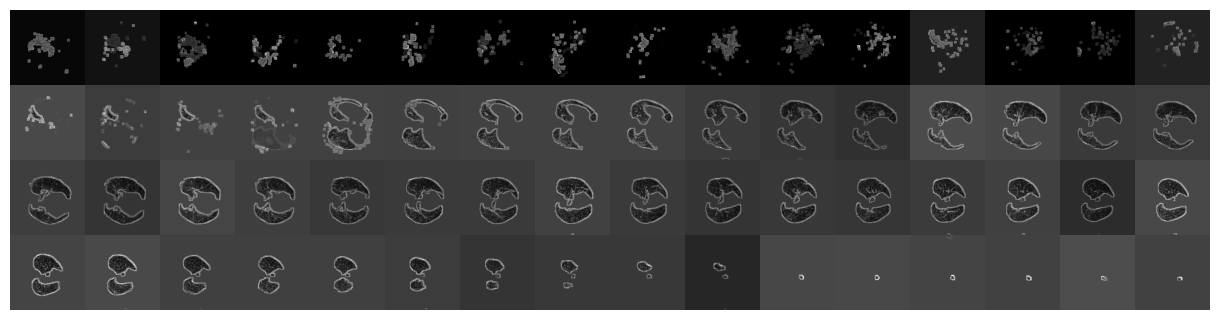

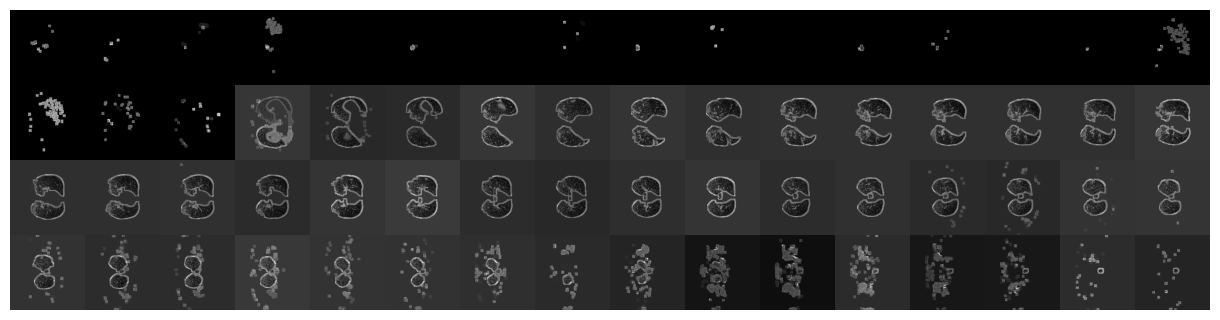

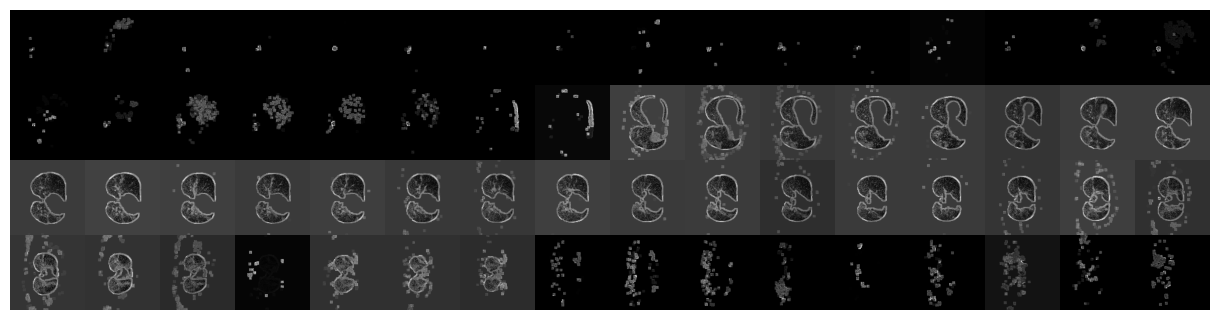

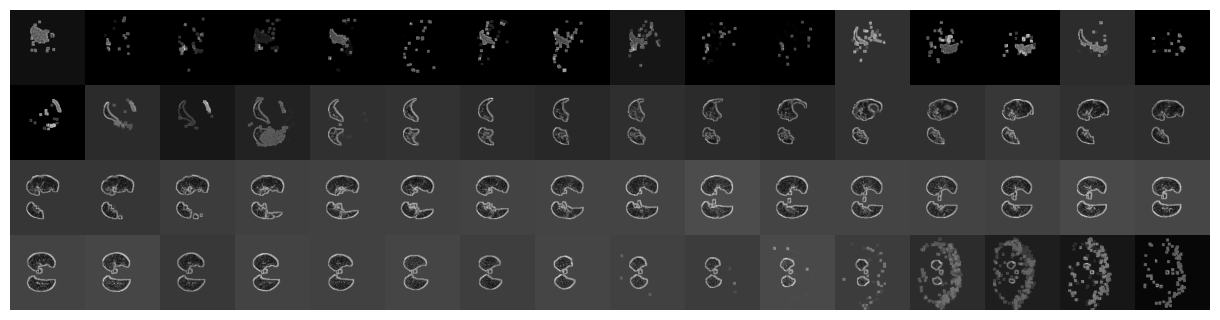

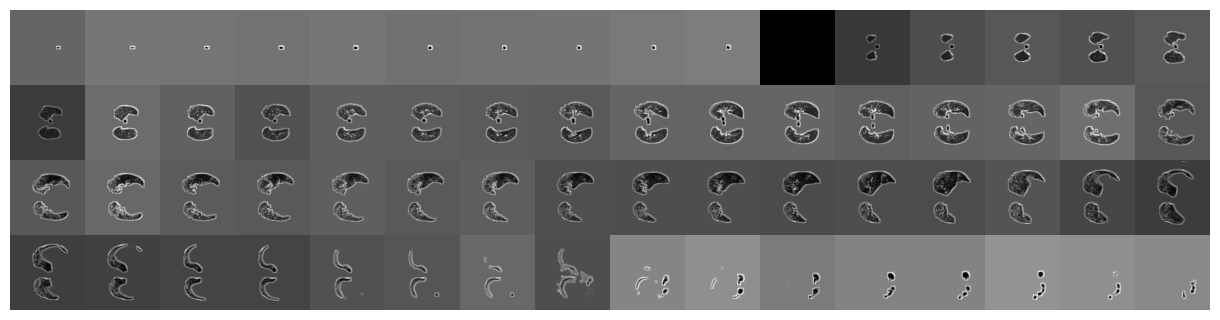

In [49]:
for i in range(np.shape(close1)[0]):
    plot_slices(4, 16, 128, 128, np.array(close1)[i,:,:,:])
    plt.show() 

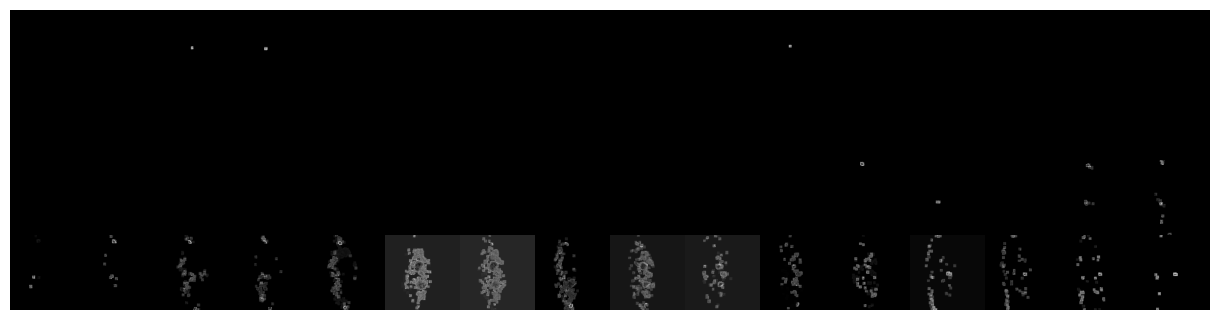

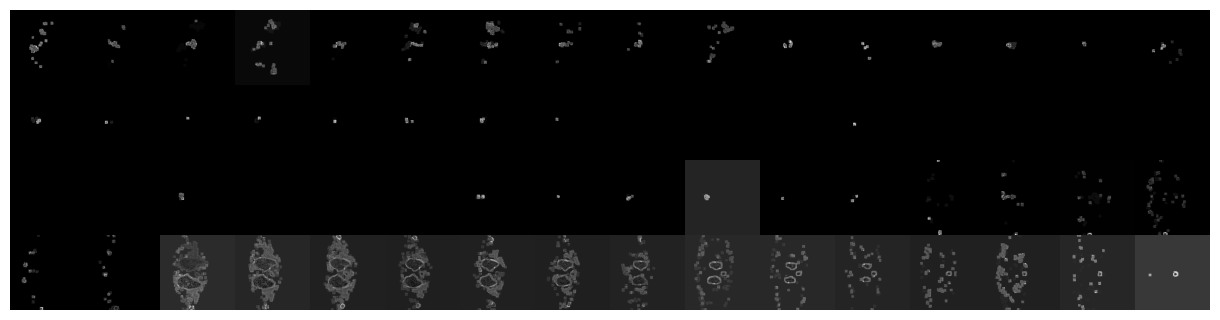

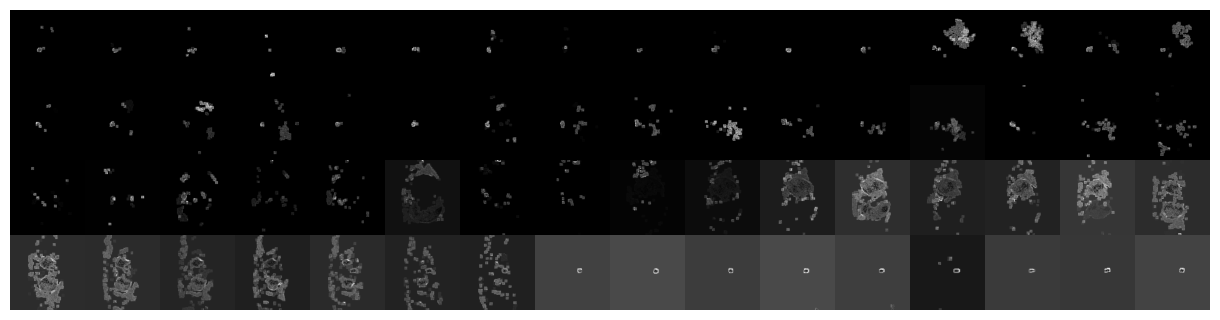

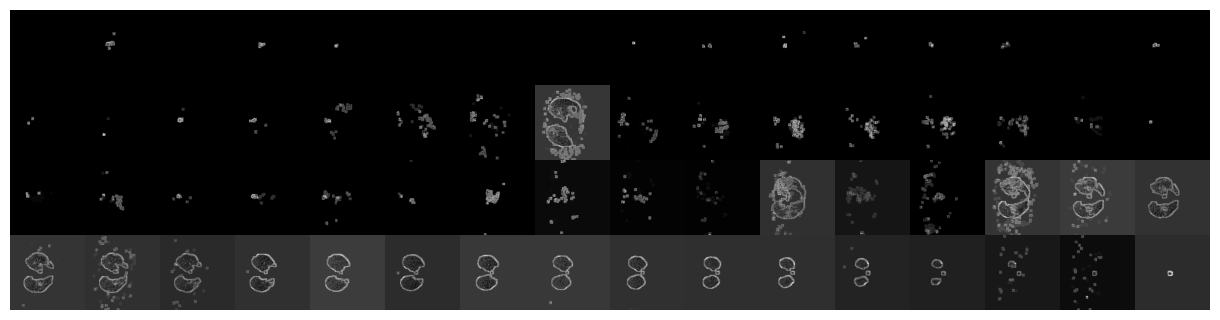

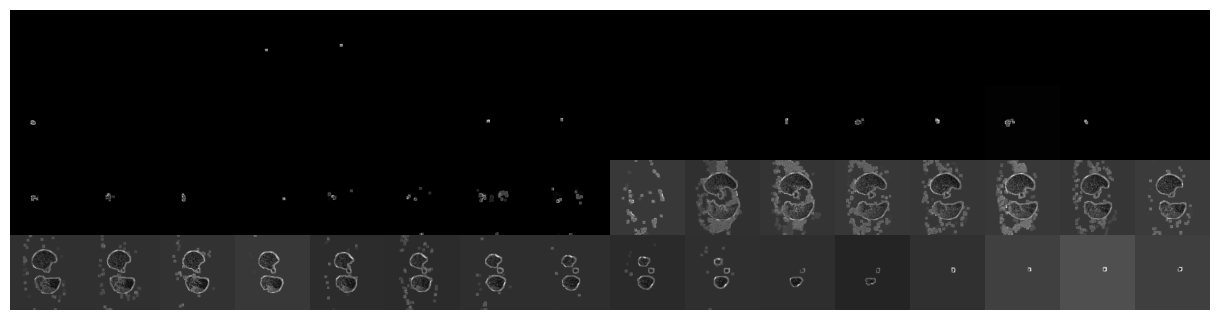

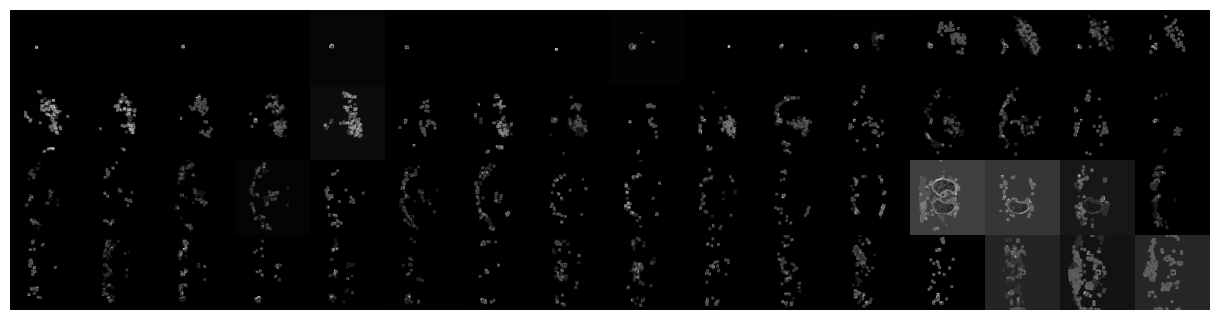

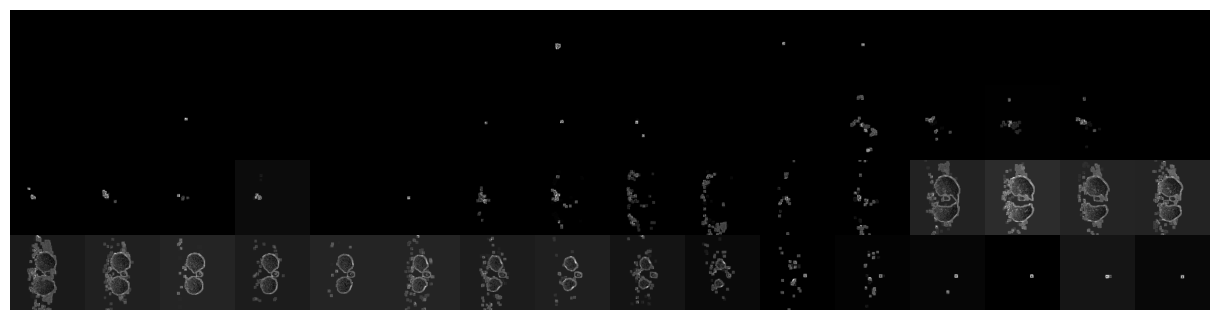

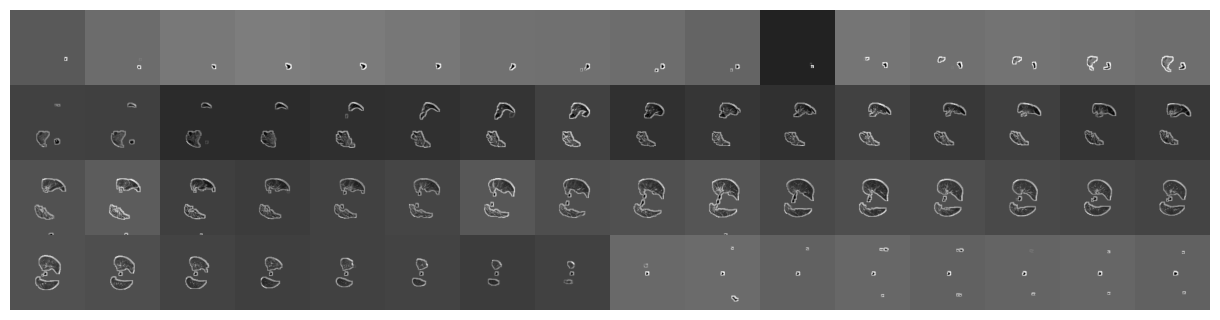

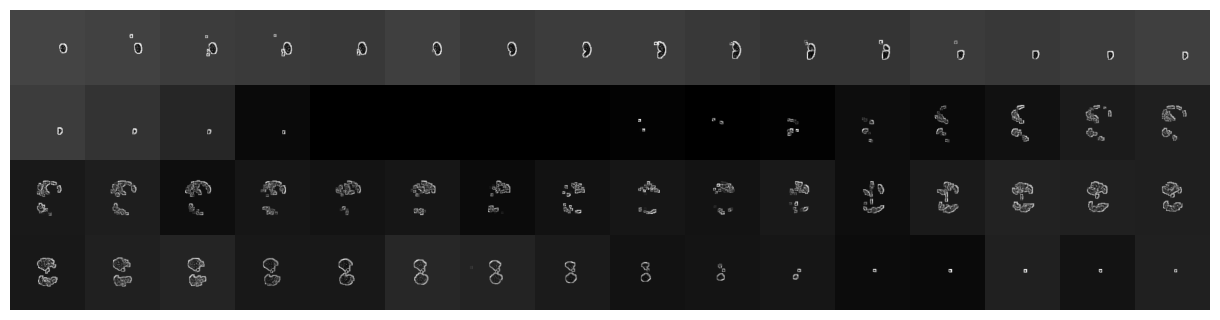

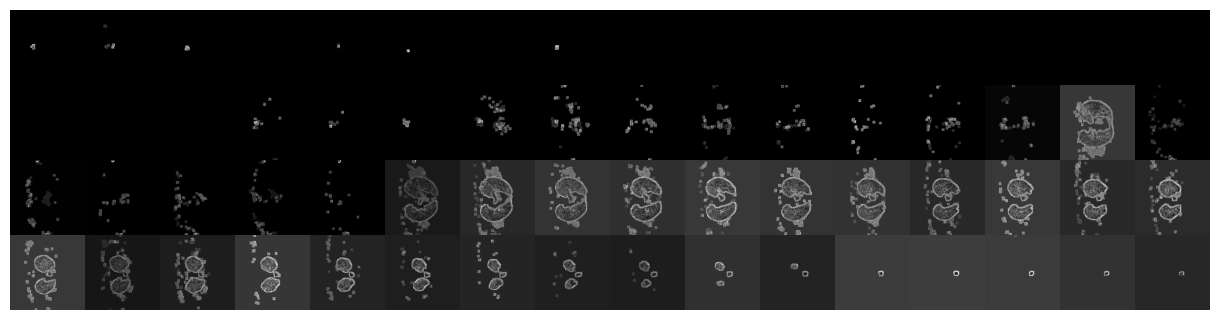

In [50]:
for i in range(np.shape(close2)[0]):
    plot_slices(4, 16, 128, 128, np.array(close2)[i,:,:,:])
    plt.show() 

In [51]:
from scipy.io import savemat
# collect arrays in dictionary
savedict = {
    'A' : superimposed_img_0,
    'B' : superimposed_img_1,
    'C' : superimposed_img_2
}

savemat("/home/norouzi1/Thesis_FinalResults/Covid/SavedModels/3DVis_IRANData.mat", savedict)